I need to fill the functions that I just used from the other files, create text explaining how to use the models, create the if statements for running the simulations or just plotting results from saved data. I think this may take 3 to 4 days, specially the explanation texts. After finishing this, I need to do a run of everything to make sure it works well. And them delete everything that it is not in this file, and put the dissertation original and the corrected version after I finishe subbitting the corrected version to the library with the links also for completeness of the repo, also put everything on zenodo and on github properly and with open code.

 # Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import scipy as scp
from tqdm.auto import tqdm
from functools import partial
from IPython.display import display
from fractions import Fraction
from core.utils import *
from core.models import *
from core.plot_funcs import *
# Create more bools for running or just loading data
run_ks = True
run_opt= True

# Utils

## Visuals of the plots

In [2]:
default_area=mpl.rcParams['figure.figsize'][0]*mpl.rcParams['figure.figsize'][1]
new_figsize=[14,8]
mpl.rcParams['figure.figsize'] = new_figsize
mpl.rcParams['lines.linewidth']=5
mpl.rcParams['xtick.minor.visible']=True
mpl.rcParams['ytick.minor.visible']=True
mpl.rcParams['axes.grid']=True
mpl.rc('xtick', labelsize=18)           # x-tick numbers only
mpl.rc('ytick', labelsize=18)           # y-tick numbers only
mpl.rcParams['figure.dpi']=300

## Comparative Tables

In [3]:
def compare_regions(data1, data2, regions, labels=["A", "B", "C"]):
    """
    Compare two datasets over given index regions.
    
    Parameters:
        data1, data2 : array-like
            The datasets to compare (must be same length).
        regions : list of tuples
            Each tuple (start, end) defines a region.
        labels : list of str
            Labels for the regions (must match len(regions)).
    
    Returns:
        summary : list of dict
            Each dict contains region label, mean diff, std dev.
    """
    summary = []

    for (start, end), label in zip(regions, labels):
        seg1 = np.array(data1[start:end])
        seg2 = np.array(data2[start:end])
        diff = seg1 - seg2
        mean_diff = np.mean(np.abs(diff))
        std_diff = np.std(diff)
        rmse = np.sqrt(np.mean(diff**2))
        summary.append({
            "region": label,
            "mean_abs_diff": mean_diff,
            "std_dev_diff": std_diff,
            "rmse": rmse,
            "max_abs_diff": np.max(np.abs(diff)),
            "min_abs_diff": np.min(np.abs(diff))
            
        })

    return summary
# To print as a simple table:
def print_summary_table(summary):
    print(f"{'Region':<8} {'Mean Abs Diff':<15} {'Std Dev Diff':<15} {'RMSE':<15} {'Max Diff':<15} {'Min Diff':<15}")
    for entry in summary:
        print(f"{entry['region']:<8} {entry['mean_abs_diff']:<15.6f} {entry['std_dev_diff']:<15.6f} {entry['rmse']:<15.6f} {entry['max_abs_diff']:<15.6f} {entry['min_abs_diff']:<15.6f}")

# Populations

## Sequence 1

In [4]:
def seq_1(dynam,laser_t,free_t,mw_t,init_state=((N1 + N2 + N3)&ID_N15)/6,progress_bar="ON",repetitions=1):
    '''
    Function to run the sequence of Magaletti et al with laser, free evolution and microwaves.
    Parameters:
    dynam: function
        The function that runs the dynamics of the system.
    laser_t: float
        Time duration for the laser on period.
    free_t: float
        Time duration for the free evolution period.
    mw_t: float
        Time duration for the microwave on period.
    init_state: qutip.Qobj
        The initial state of the system. Default is equal superposition of ground states.
    progress_bar: str
        Option to show progress bar during calculations. Default is "ON".
    Returns:
    times: np.ndarray
        Array of times for the entire sequence.
    results: np.ndarray
        Array of result objects from each segment of the sequence.
    tis: list
        List of start times for each segment.
    tfs: list
        List of end times for each segment.
        
    '''
    # Initial state where the ground state is evenly populated
    #init_state = 1 / 3 * (n1 + n2 + n3)
    # Array to collect the result Class
    results = np.array([])

    # Initial time of the evolution
    ti = 0.0

    # Store the times of activation and deativation of laser and microwaves for region highlight in plotting
    tis = []
    tfs = []

    # Set the number of times to repeat the Sequence
    n_rep = repetitions
    # Set the time intervals for each part of the evolution (with laser, with microwaves and free evolution)
    dt_laser = laser_t
    dt_free = free_t
    dt_mw = mw_t
    print("Starting calculations, this may take a while...")
    # This loop is defined to reproduce the Sequence of Magalleti el al
    for i in tqdm(range(n_rep)):
        tis.append(ti)
        # Here Laser is ON
        # Run the dynamics_no based on the mode choosen
        tf, result = dynam(
            dt_laser,
            init_state,
            ti=ti,
            mode="Laser",
            progress_bar=progress_bar,
            i=i,
        ) # type:ignore
        # Store the Result class for when the Laser is on
        results = np.append(results, result) # type: ignore 
        # Save the initial state for the next part of the Sequence
        init_state = result.states[-1]
        # Make the initial time the end time of the previous part of the procotol
        ti = tf
        tfs.append(tf)
        # Run the dynamics_no based on the mode choosen
        tf, result = dynam(
            dt_free,
            init_state,
            ti=ti,
            mode="Free",
            progress_bar=progress_bar,
            i=i,
        ) # type:ignore
        # Store the Result class for MW on evolution
        results = np.append(results, result) # type: ignore 
        # Save the times for coloring areas of the plot
        tis.append(ti)
        tfs.append(tf)
        # Make initial time to be the end time of the last part of the Sequence
        ti = tf
        # Make the last state  of this evolution step be the initial states of the next iteration
        init_state = result.states[-1]
        # Run the dynamics_no based on the mode choosen
        tf, result = dynam(dt_mw, 
                              init_state, 
                              ti=ti, 
                              mode="MW", 
                              progress_bar=progress_bar, 
                              i=i) # type:ignore
        # Store the Result class for MW on evolution
        results = np.append(results, result) # type: ignore
        # Save the times for coloring areas of the plot
        tis.append(ti)
        tfs.append(tf)
        # Make initial time to be the end time of the last part of the Sequence
        ti = tf
        # Make the last state  of this evolution step be the initial states of the next iteration
        init_state = result.states[-1]
    # Times for the entire sequence
    times = np.concatenate([res.times for res in results])
    print("Calculations are finished!! Go to the next block for plots")
    return times, results, tis, tfs

## Model 1

Starting calculations, this may take a while...


  0%|          | 0/1 [00:00<?, ?it/s]

Laser 1 
 ti | tf 
 0 | 10


  0%|          | 0/5000 [00:00<?, ?it/s]

Free 1 
 ti | tf 
 10 | 11


  0%|          | 0/1000 [00:00<?, ?it/s]

MW 1 
 ti | tf 
 11 | 16


  0%|          | 0/1000 [00:00<?, ?it/s]

Calculations are finished!! Go to the next block for plots


c:\Users\artur\anaconda3\envs\qutip\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\artur\anaconda3\envs\qutip\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\artur\anaconda3\envs\qutip\Lib\site-packages\numpy\ma\core.py:2892: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\artur\anaconda3\envs\qutip\Lib\site-packages\matplotlib\transforms.py:2876: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


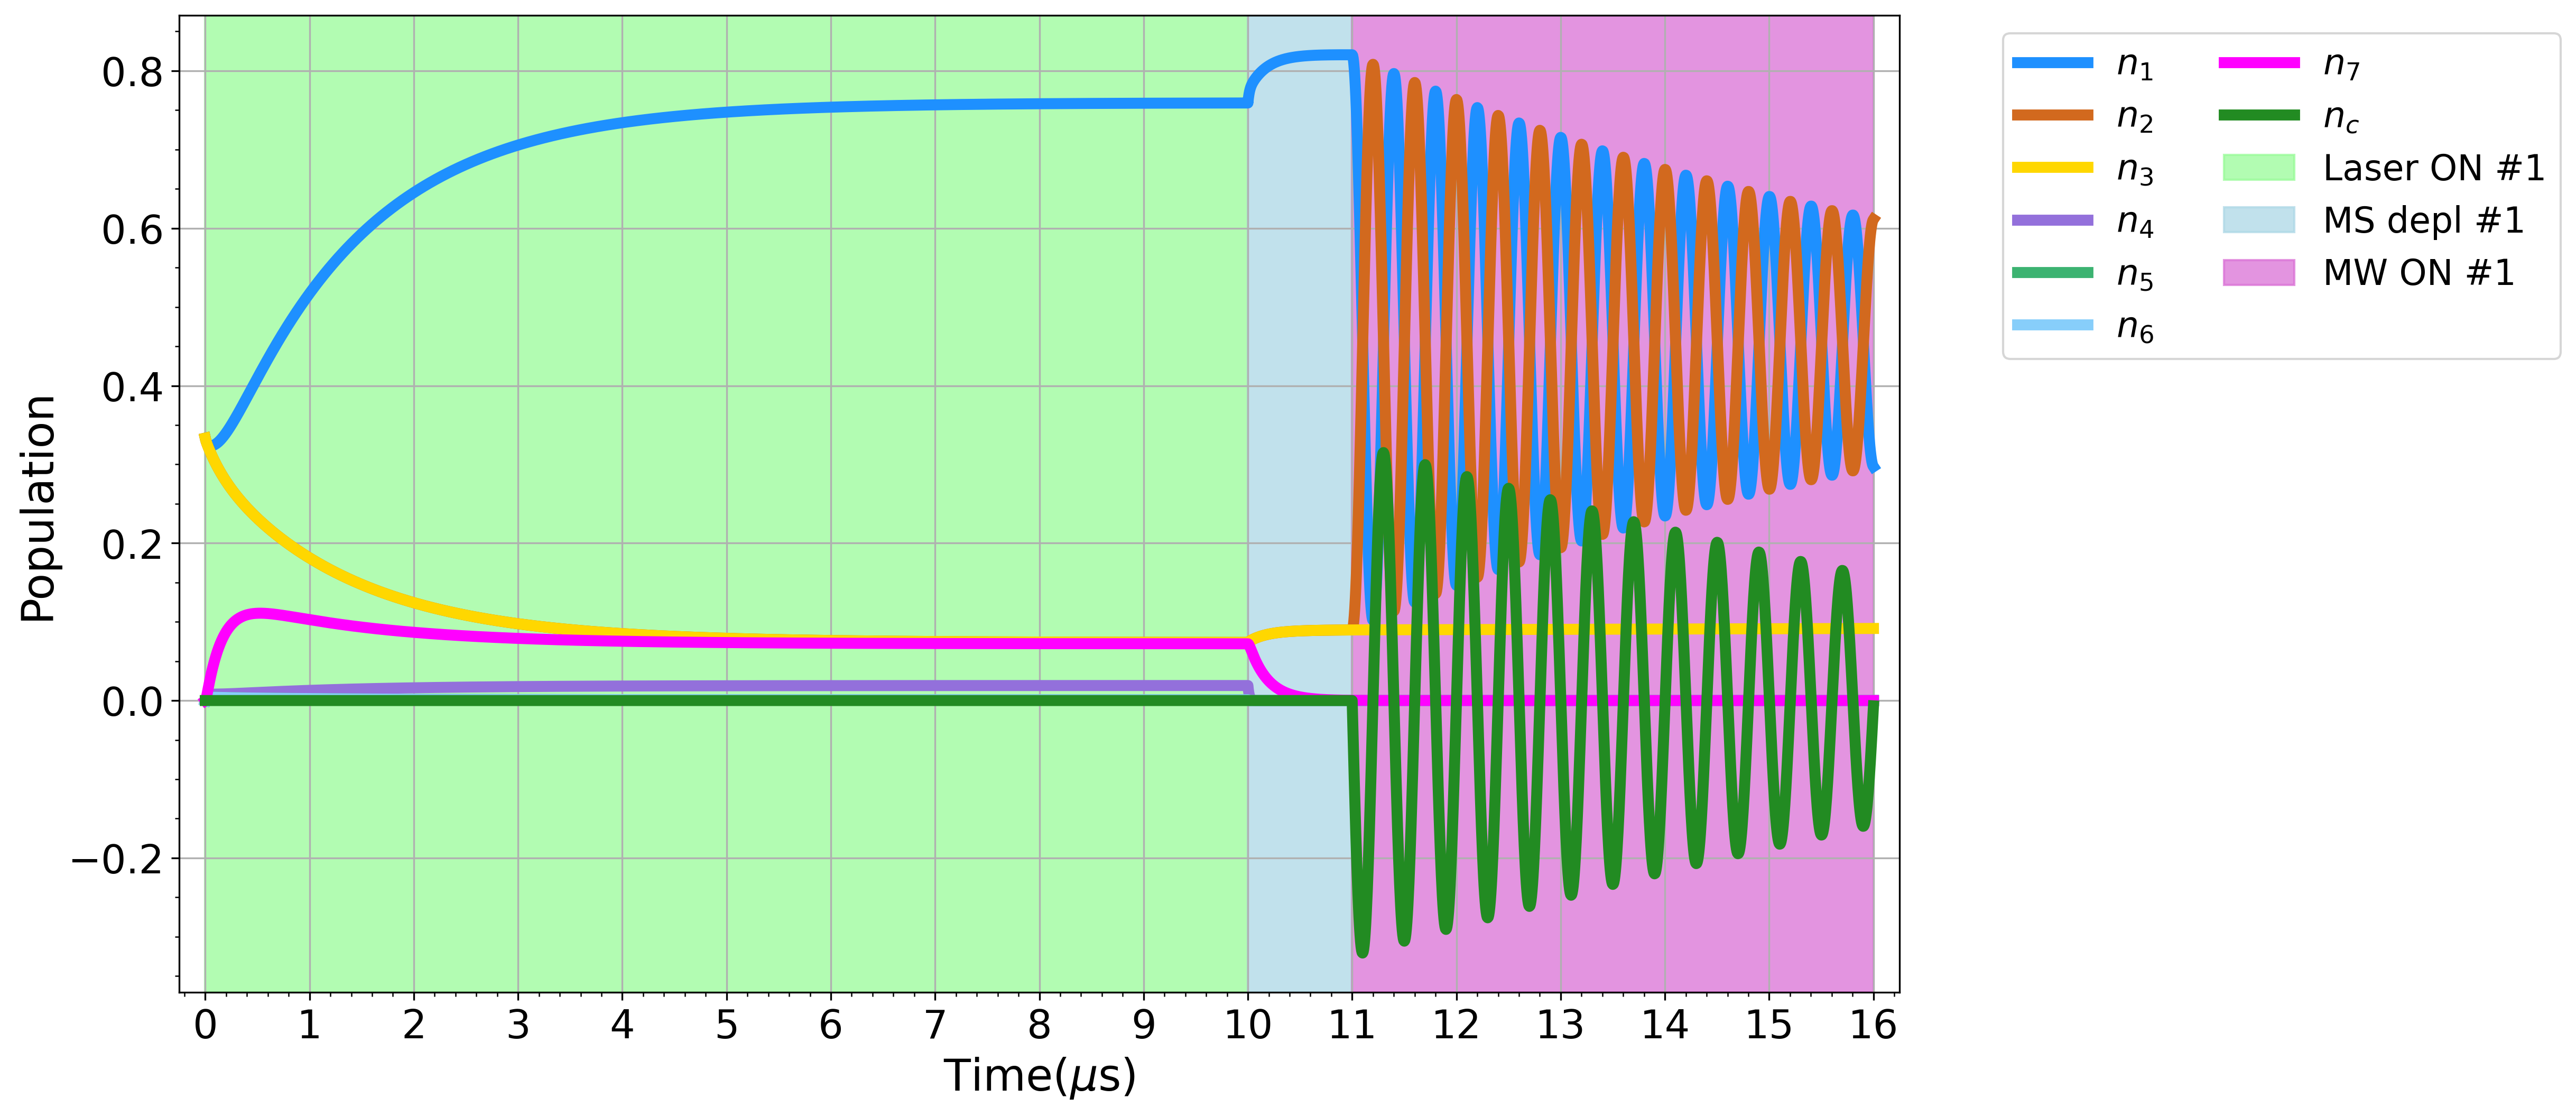

In [5]:
times_m1, results_m1, tis_m1, tfs_m1 = seq_1(dynam=dynamics_mg,
                                            laser_t=10.0,
                                            free_t=1.0,
                                            mw_t=5.0,
                                            init_state=(N1 + N2 + N3)/3,
                                            )
n_exp_m1=np.array([np.concatenate([qt.expect(M, res.states) for res in results_m1]) for M in [N1, N2, N3, N4, N5, N6, N7, NC]])
plot_popul(n_exp_m1, times_m1, tis_m1, tfs_m1)

### With Hyperfine (HF)

Starting calculations, this may take a while...


  0%|          | 0/1 [00:00<?, ?it/s]

Laser 1 
 ti | tf 
 0 | 10


  0%|          | 0/5000 [00:00<?, ?it/s]

Free 1 
 ti | tf 
 10 | 11


  0%|          | 0/1000 [00:00<?, ?it/s]

MW 1 
 ti | tf 
 11 | 16


  0%|          | 0/1000 [00:00<?, ?it/s]

Calculations are finished!! Go to the next block for plots


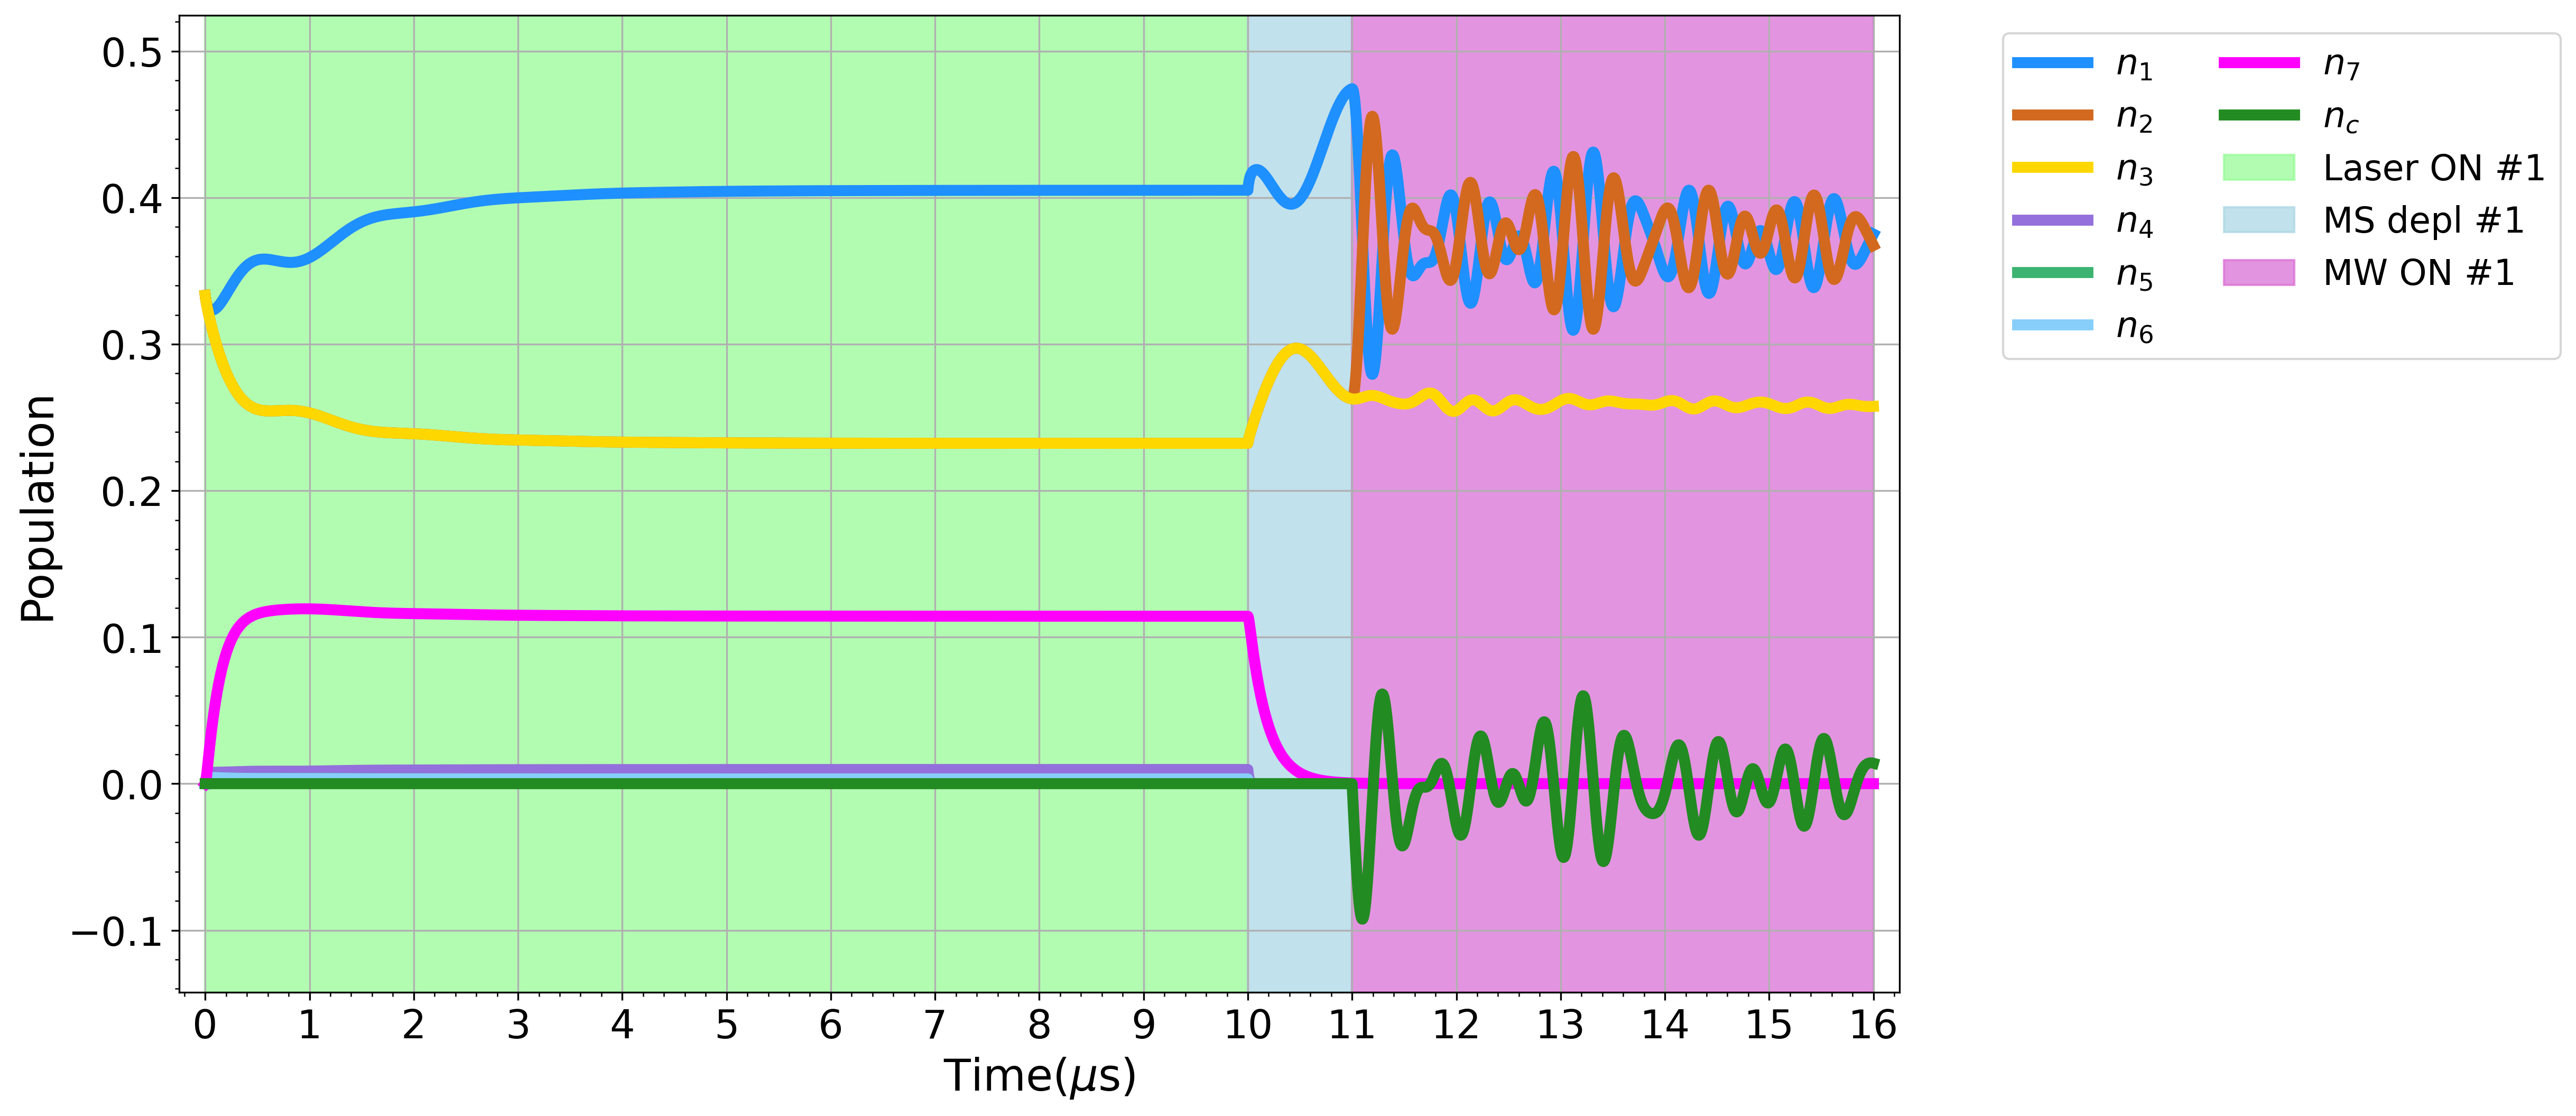

In [6]:
times_m1_hf, results_m1_hf, tis_m1_hf, tfs_m1_hf = seq_1(dynam=dynamics_mg_hf,
                                            laser_t=10.0,
                                            free_t=1.0,
                                            mw_t=5.0,
                                            #init_state=(N1 + N2 + N3)/3,
                                            )
n_exp_m1_hf=np.array([np.concatenate([qt.expect(M, res.states) for res in results_m1_hf]) for M in [N1&ID_N15, N2&ID_N15, N3&ID_N15, N4&ID_N15, N5&ID_N15, N6&ID_N15, N7&ID_N15, NC&ID_N15]])
plot_popul(n_exp_m1_hf, times_m1_hf, tis_m1_hf, tfs_m1_hf)

### Comparisson between HF and No-HF

c:\Users\artur\anaconda3\envs\qutip\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\artur\anaconda3\envs\qutip\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\artur\anaconda3\envs\qutip\Lib\site-packages\numpy\ma\core.py:2892: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\artur\anaconda3\envs\qutip\Lib\site-packages\matplotlib\transforms.py:2876: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


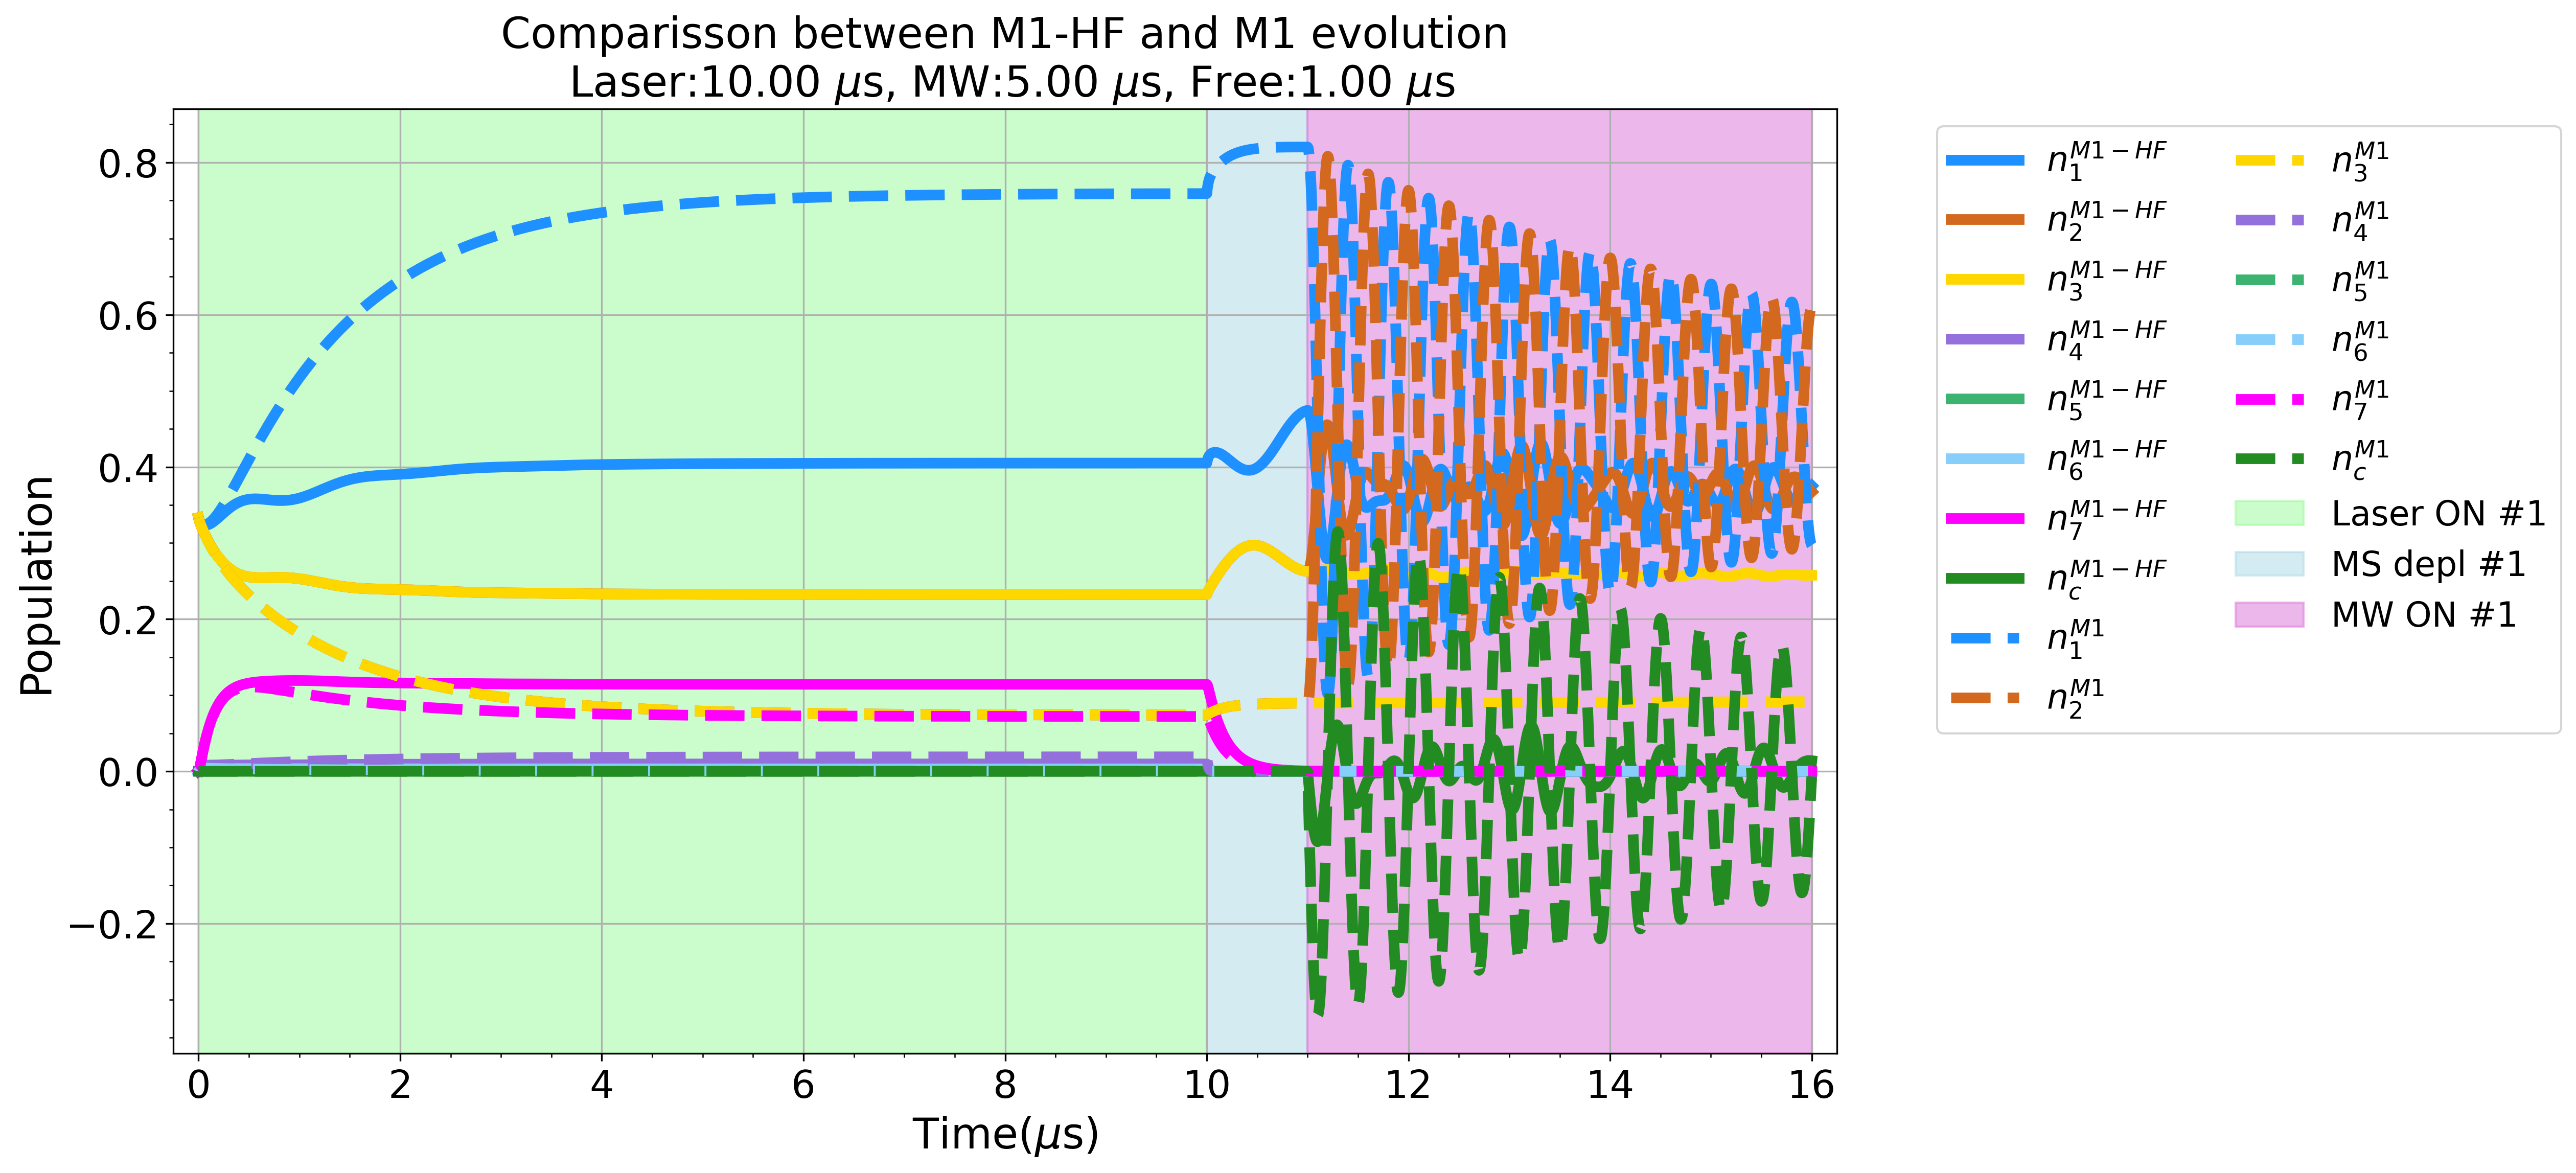

In [15]:
plot_popul_comp(n_exp_m1_hf,times_m1_hf,tis_m1_hf,tfs_m1_hf,
                n_exp_m1,times_m1,tis_m1,tfs_m1,
                name_1="{M1-HF}",name_2="{M1}")

## Model 2

Starting calculations, this may take a while...


  0%|          | 0/1 [00:00<?, ?it/s]

Laser 1 
 ti    |    tf 
 0.00 | 10.00


  0%|          | 0/5000 [00:00<?, ?it/s]

Free 1 
 ti    |    tf 
 10.00 | 11.00


  0%|          | 0/1000 [00:00<?, ?it/s]

MW 1 
 ti    |    tf 
 11.00 | 16.00


  0%|          | 0/1000 [00:00<?, ?it/s]

Calculations are finished!! Go to the next block for plots


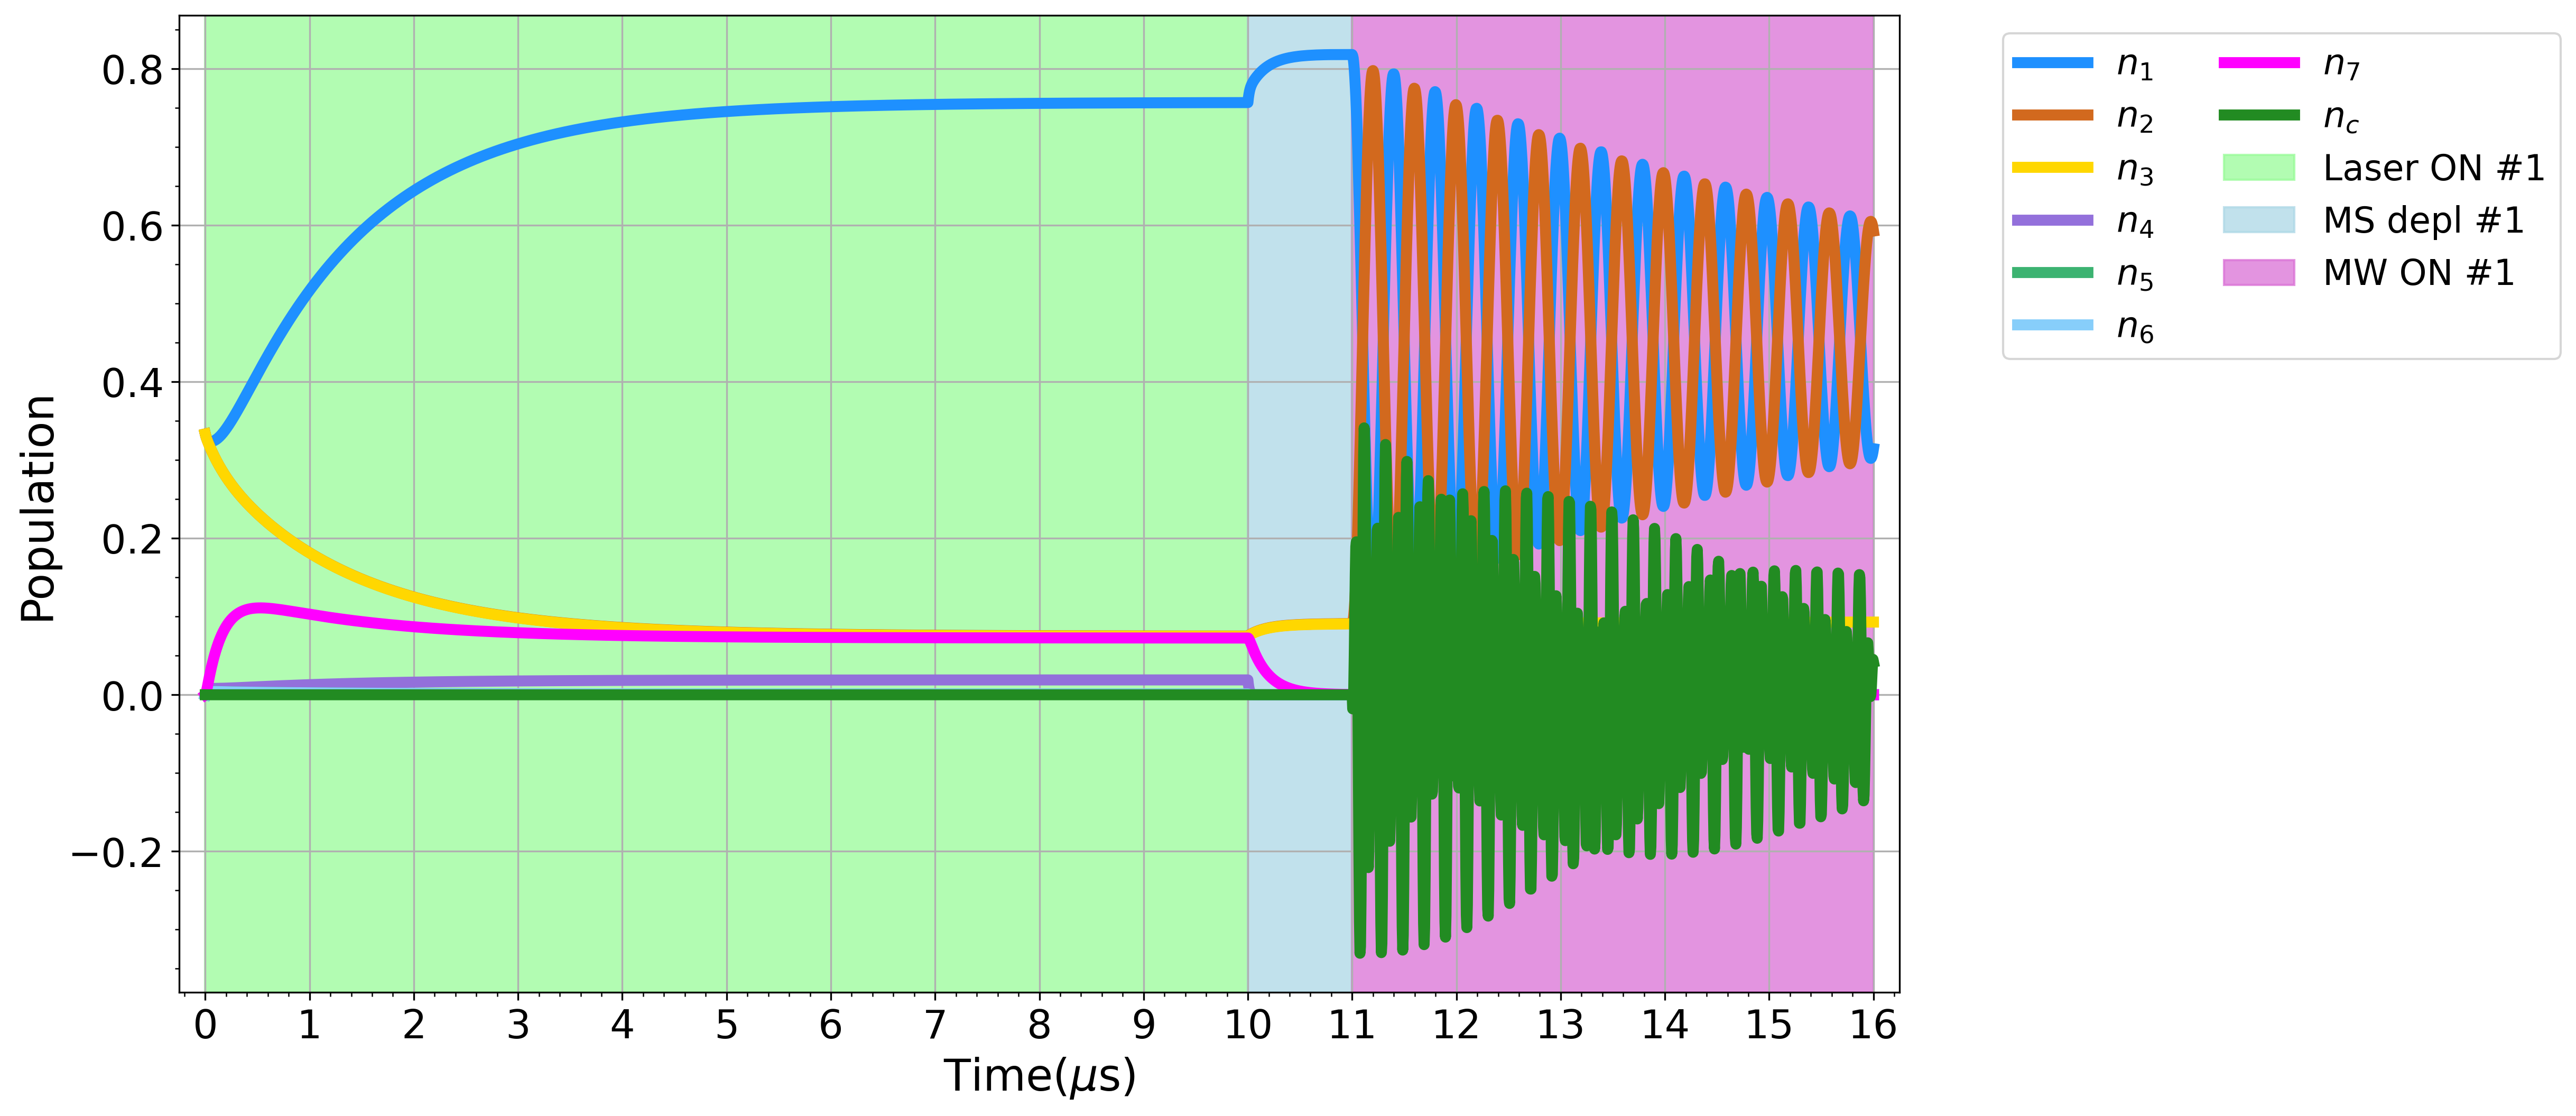

In [7]:
times_m2_hf, results_m2_hf, tis_m2_hf, tfs_m2_hf = seq_1(dynam=dynamics_dua_hf,
                                            laser_t=10.0,
                                            free_t=1.0,
                                            mw_t=5.0,
                                            #init_state=(N1 + N2 + N3)/3,
                                            )
n_exp_m2_hf=np.array([np.concatenate([qt.expect(M, res.states) for res in results_m2_hf]) for M in [N1&ID_N15, N2&ID_N15, N3&ID_N15, N4&ID_N15, N5&ID_N15, N6&ID_N15, N7&ID_N15, NC&ID_N15]])
plot_popul(n_exp_m2_hf, times_m2_hf, tis_m2_hf, tfs_m2_hf)

### Comparing with Model 1

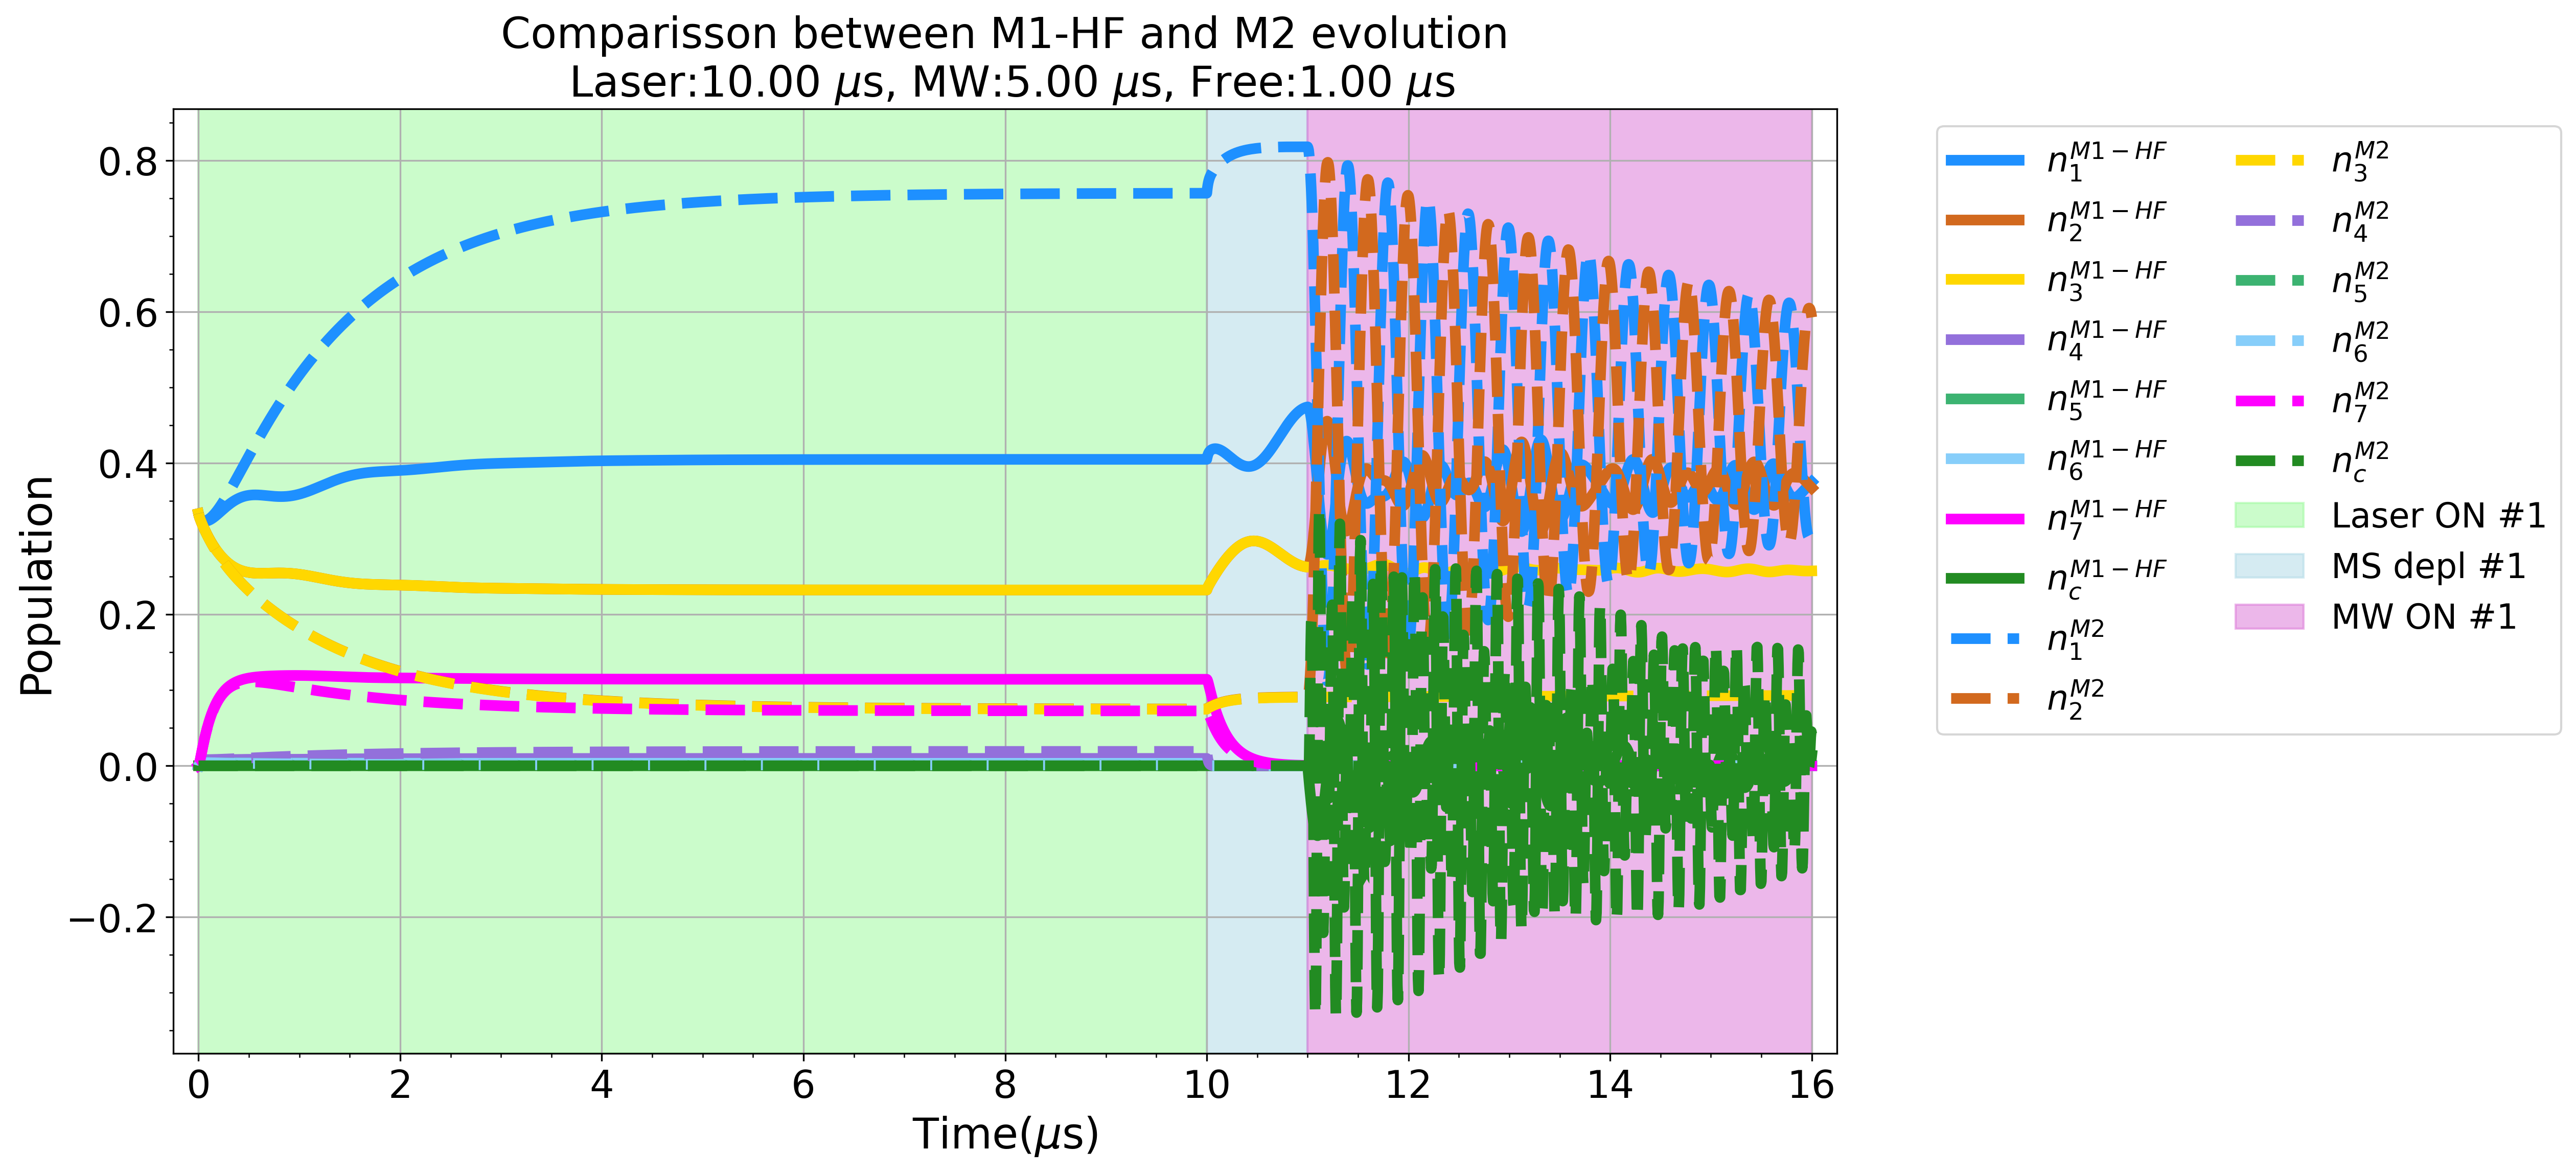

In [8]:
plot_popul_comp(n_exp_m1_hf,times_m1_hf,tis_m1_hf,tfs_m1_hf,
                n_exp_m2_hf,times_m2_hf,tis_m2_hf,tfs_m2_hf,
                name_1="{M1-HF}",name_2="{M2}")

### Comparing without HF

Starting calculations, this may take a while...


  0%|          | 0/1 [00:00<?, ?it/s]

Laser 1 
 ti    |    tf 
 0.00 | 10.00


  0%|          | 0/5000 [00:00<?, ?it/s]

Free 1 
 ti    |    tf 
 10.00 | 11.00


  0%|          | 0/1000 [00:00<?, ?it/s]

MW 1 
 ti    |    tf 
 11.00 | 16.00


  0%|          | 0/1000 [00:00<?, ?it/s]

Calculations are finished!! Go to the next block for plots


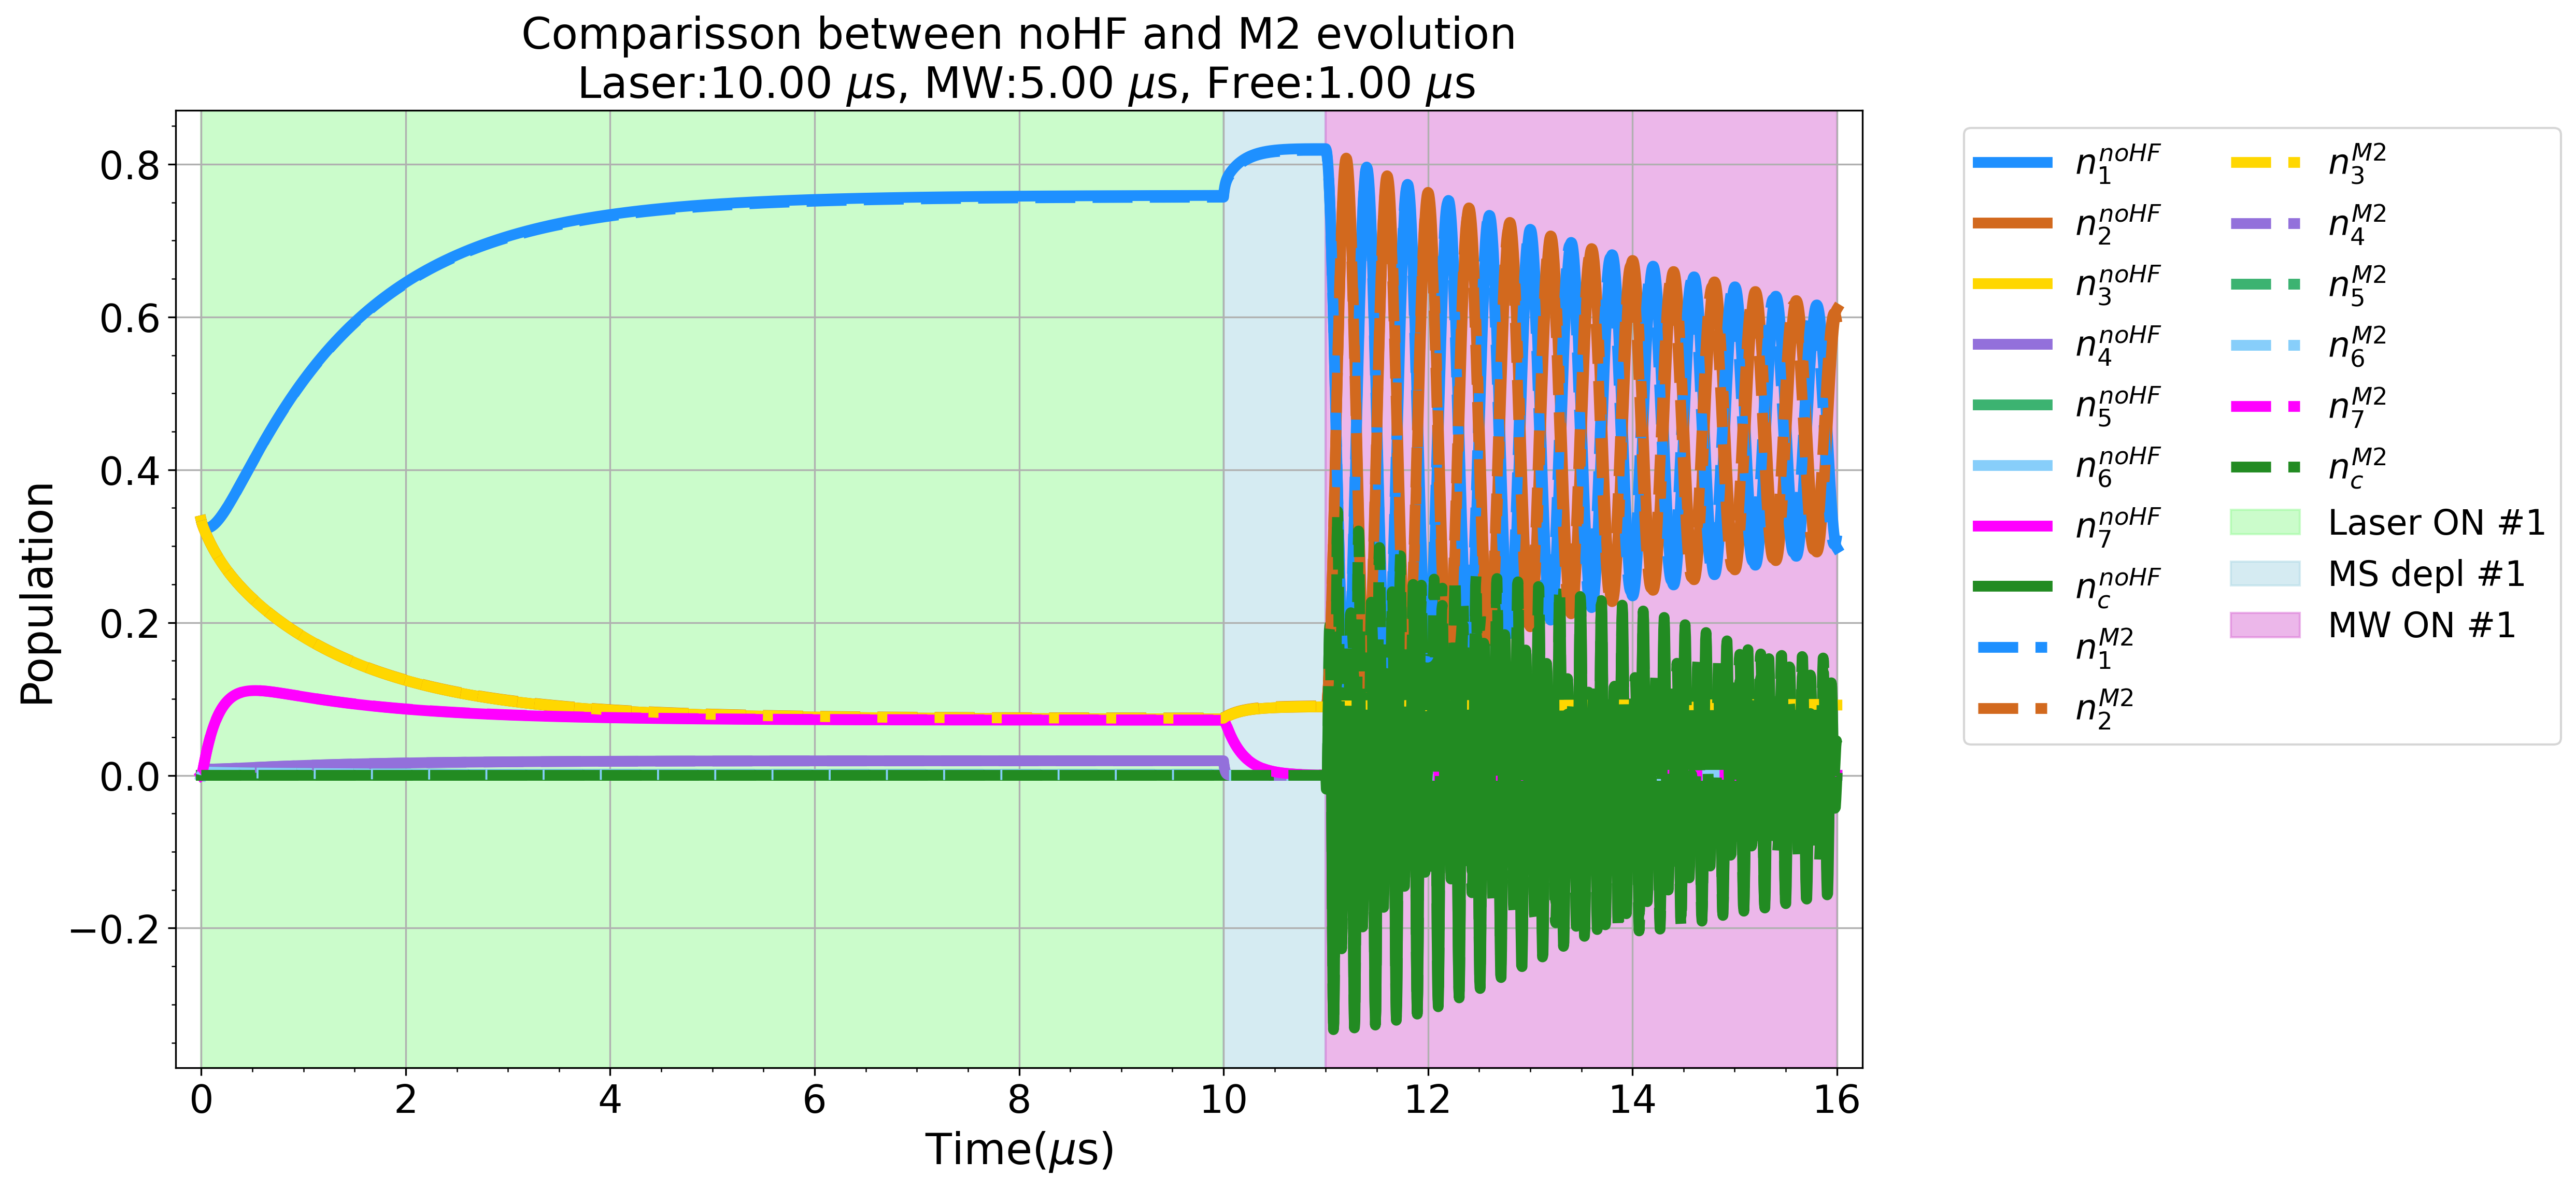

In [9]:
times_m3_no_hf, results_m3_no_hf, tis_m3_no_hf, tfs_m3_no_hf = seq_1(dynam=dynamics_no,
                                            laser_t=10.0,
                                            free_t=1.0,
                                            mw_t=5.0,
                                            init_state=(N1 + N2 + N3)/3,
                                            )
n_exp_m3_no_hf=np.array([np.concatenate([qt.expect(M, res.states) for res in results_m3_no_hf]) for M in [N1, N2, N3, N4, N5, N6, N7, NC]])
plot_popul_comp(n_exp_m3_no_hf,times_m3_no_hf,tis_m3_no_hf,tfs_m3_no_hf,
                n_exp_m2_hf,times_m2_hf,tis_m2_hf,tfs_m2_hf,
                name_1="{noHF}",name_2="{M2}")

## Model 3

Starting calculations, this may take a while...


  0%|          | 0/1 [00:00<?, ?it/s]

Laser 1 
 ti    |    tf 
 0.00 | 10.00


  0%|          | 0/5000 [00:00<?, ?it/s]

Free 1 
 ti    |    tf 
 10.00 | 11.00


  0%|          | 0/1000 [00:00<?, ?it/s]

MW 1 
 ti    |    tf 
 11.00 | 16.00


  0%|          | 0/1000 [00:00<?, ?it/s]

Calculations are finished!! Go to the next block for plots


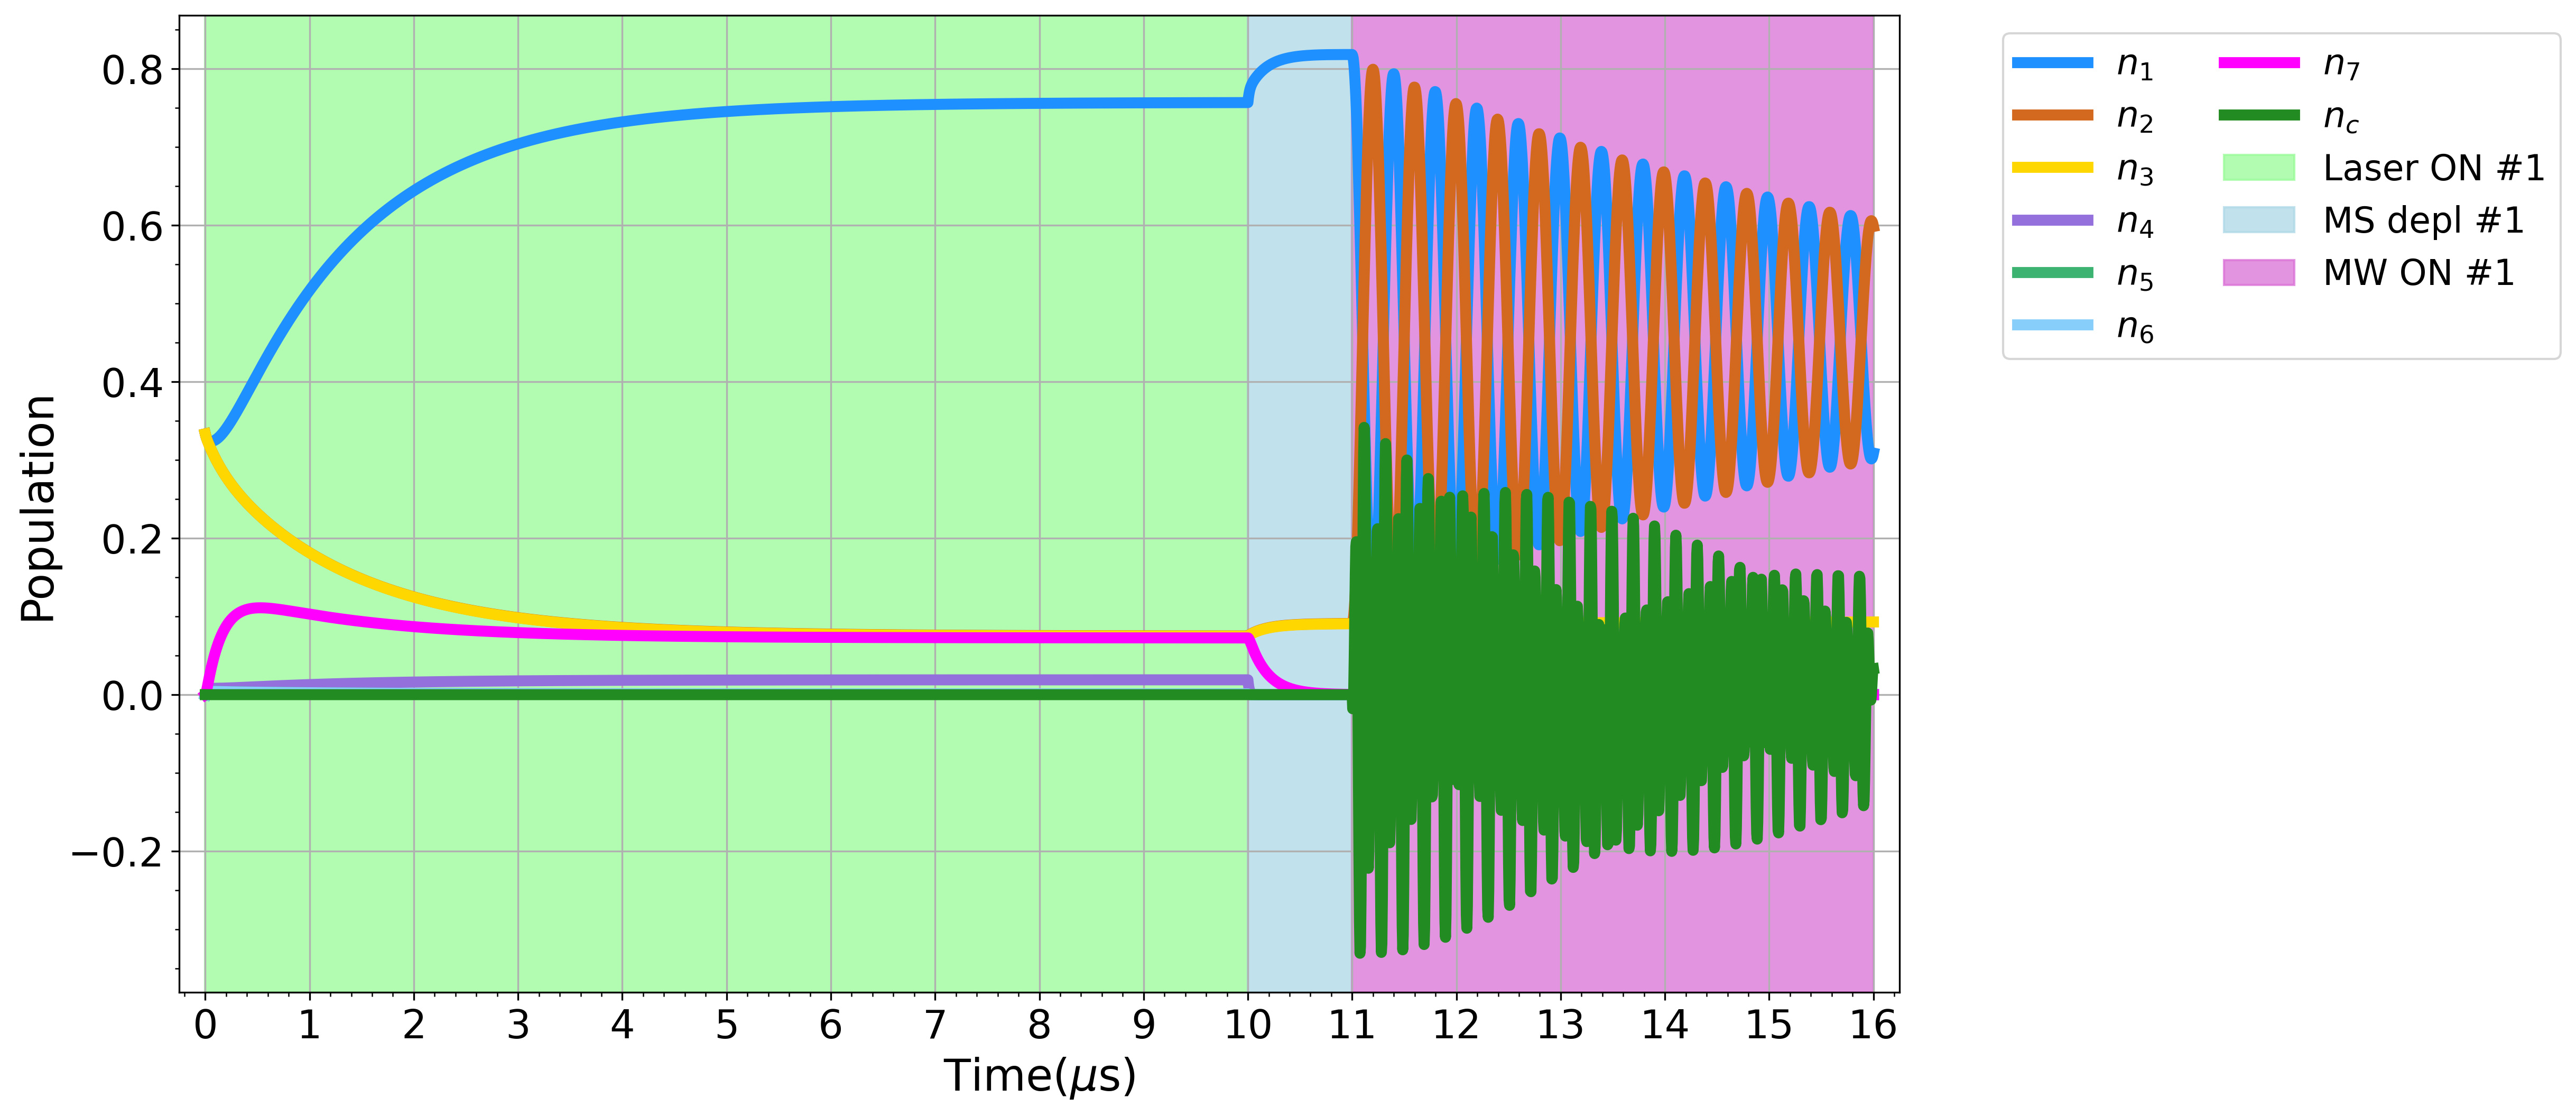

In [10]:
times_m3, results_m3, tis_m3, tfs_m3 = seq_1(dynam=dynamics_doh_hf,
                                            laser_t=10.0,
                                            free_t=1.0,
                                            mw_t=5.0,
                                            #init_state=(N1 + N2 + N3)/3,
                                            )
n_exp_m3=np.array([np.concatenate([qt.expect(M, res.states) for res in results_m3]) for M in [N1&ID_N15, N2&ID_N15, N3&ID_N15, N4&ID_N15, N5&ID_N15, N6&ID_N15, N7&ID_N15, NC&ID_N15]])
plot_popul(n_exp_m3, times_m3, tis_m3, tfs_m3)

### Comparing with Model 1

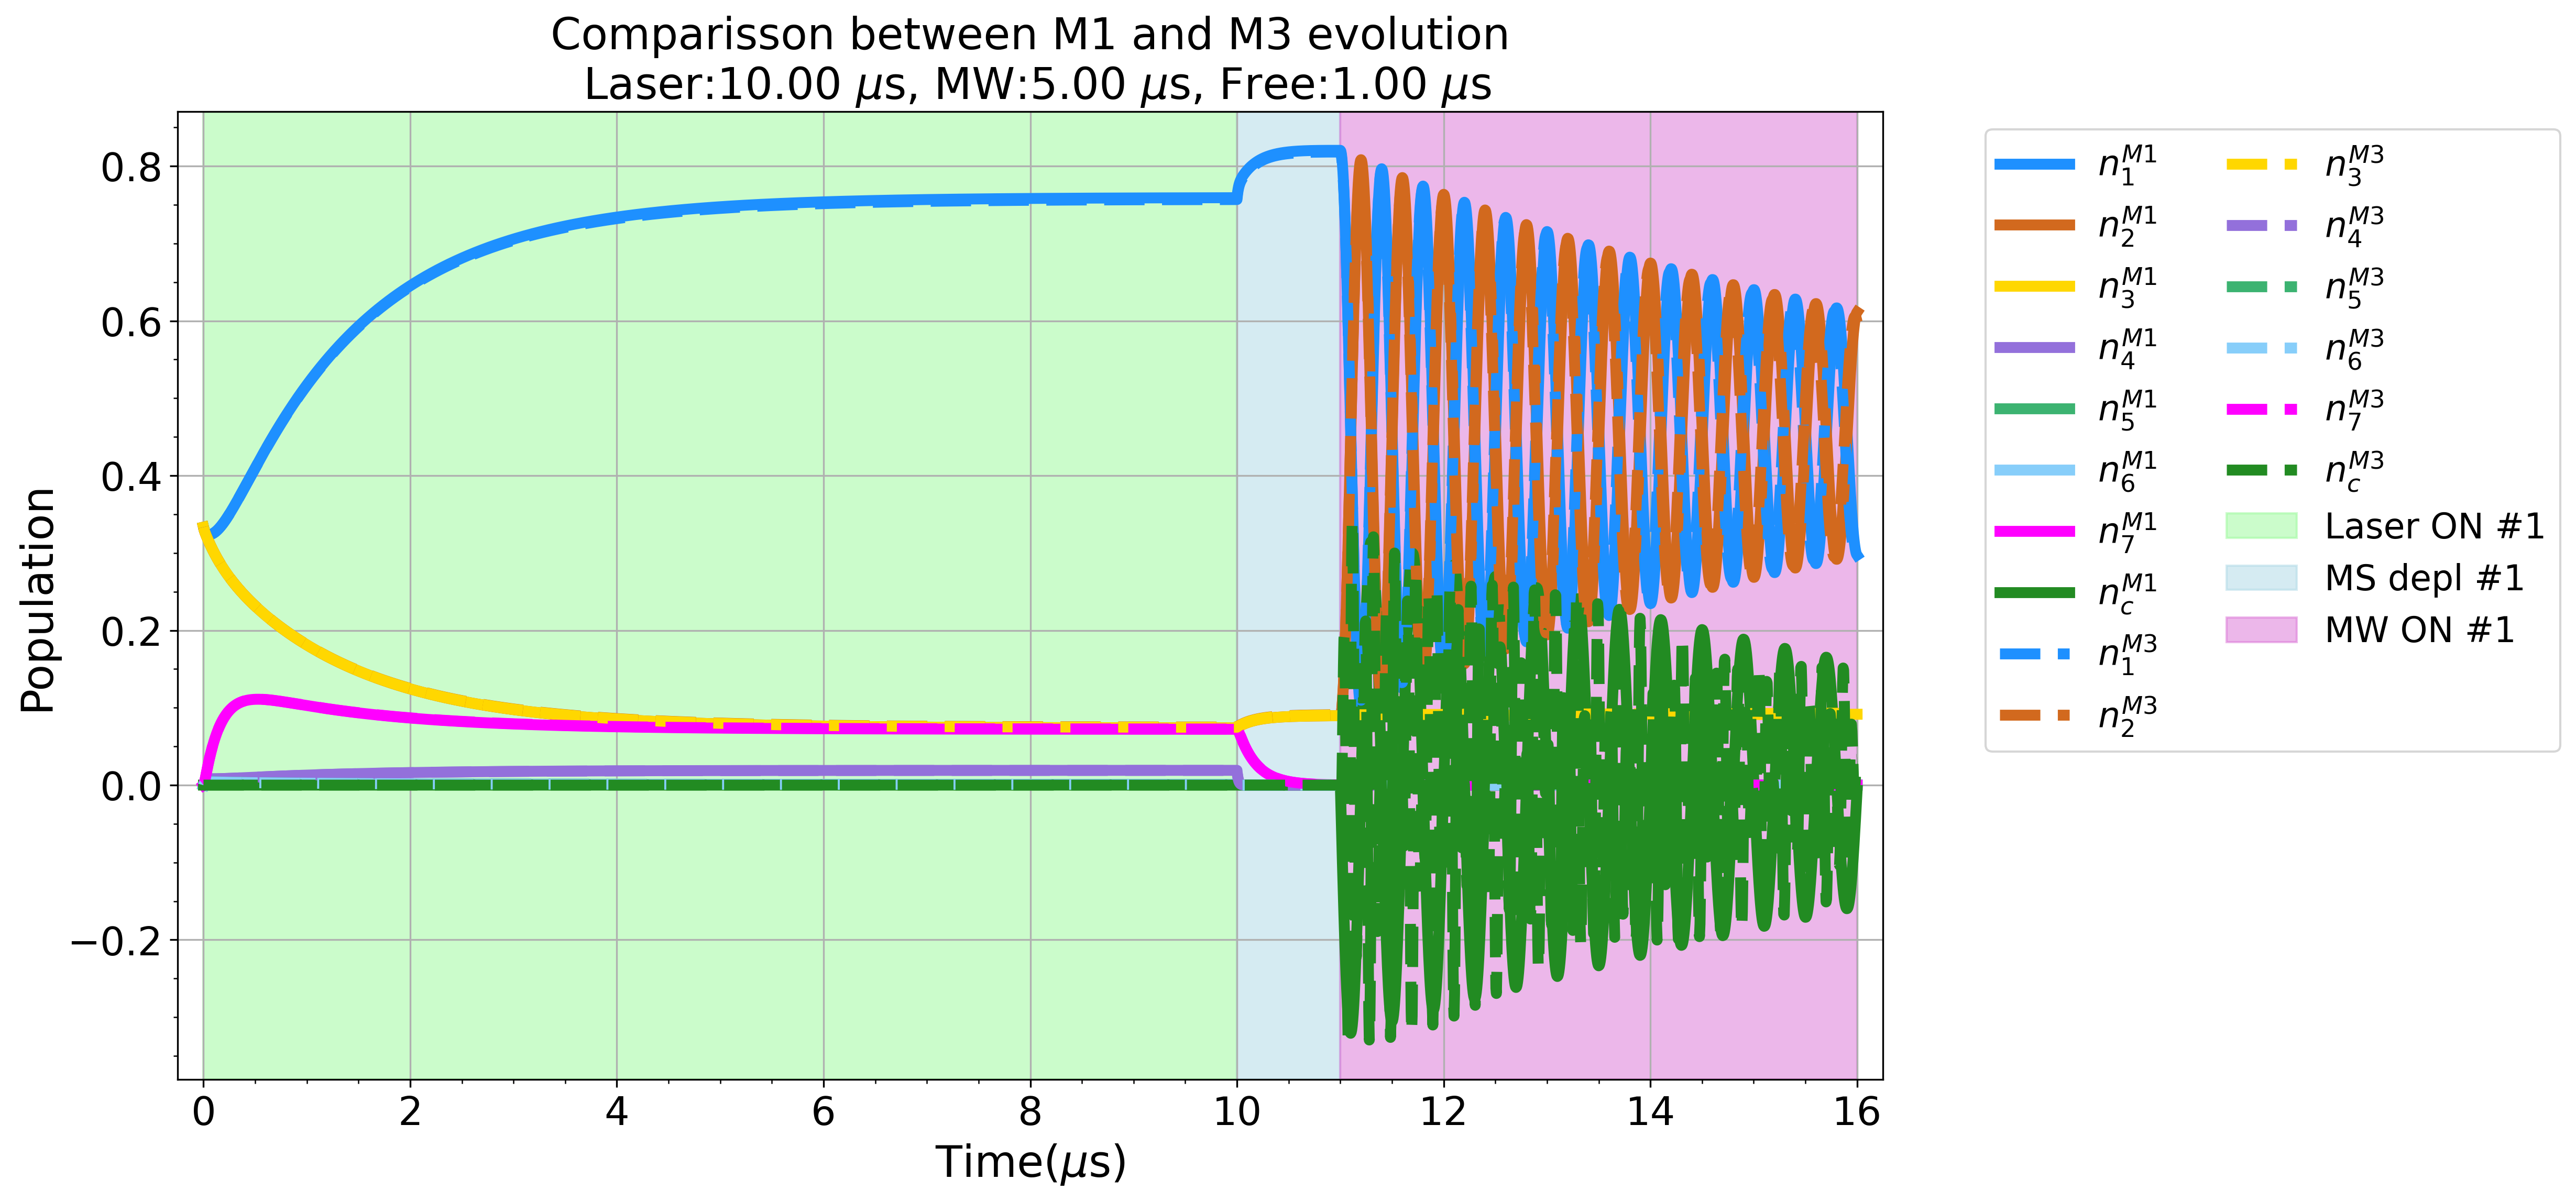

In [11]:
plot_popul_comp(n_exp_m1,times_m1,tis_m1,tfs_m1,
                n_exp_m3,times_m3,tis_m3,tfs_m3,
                name_1="{M1}",name_2="{M3}")

### Comparing without HF

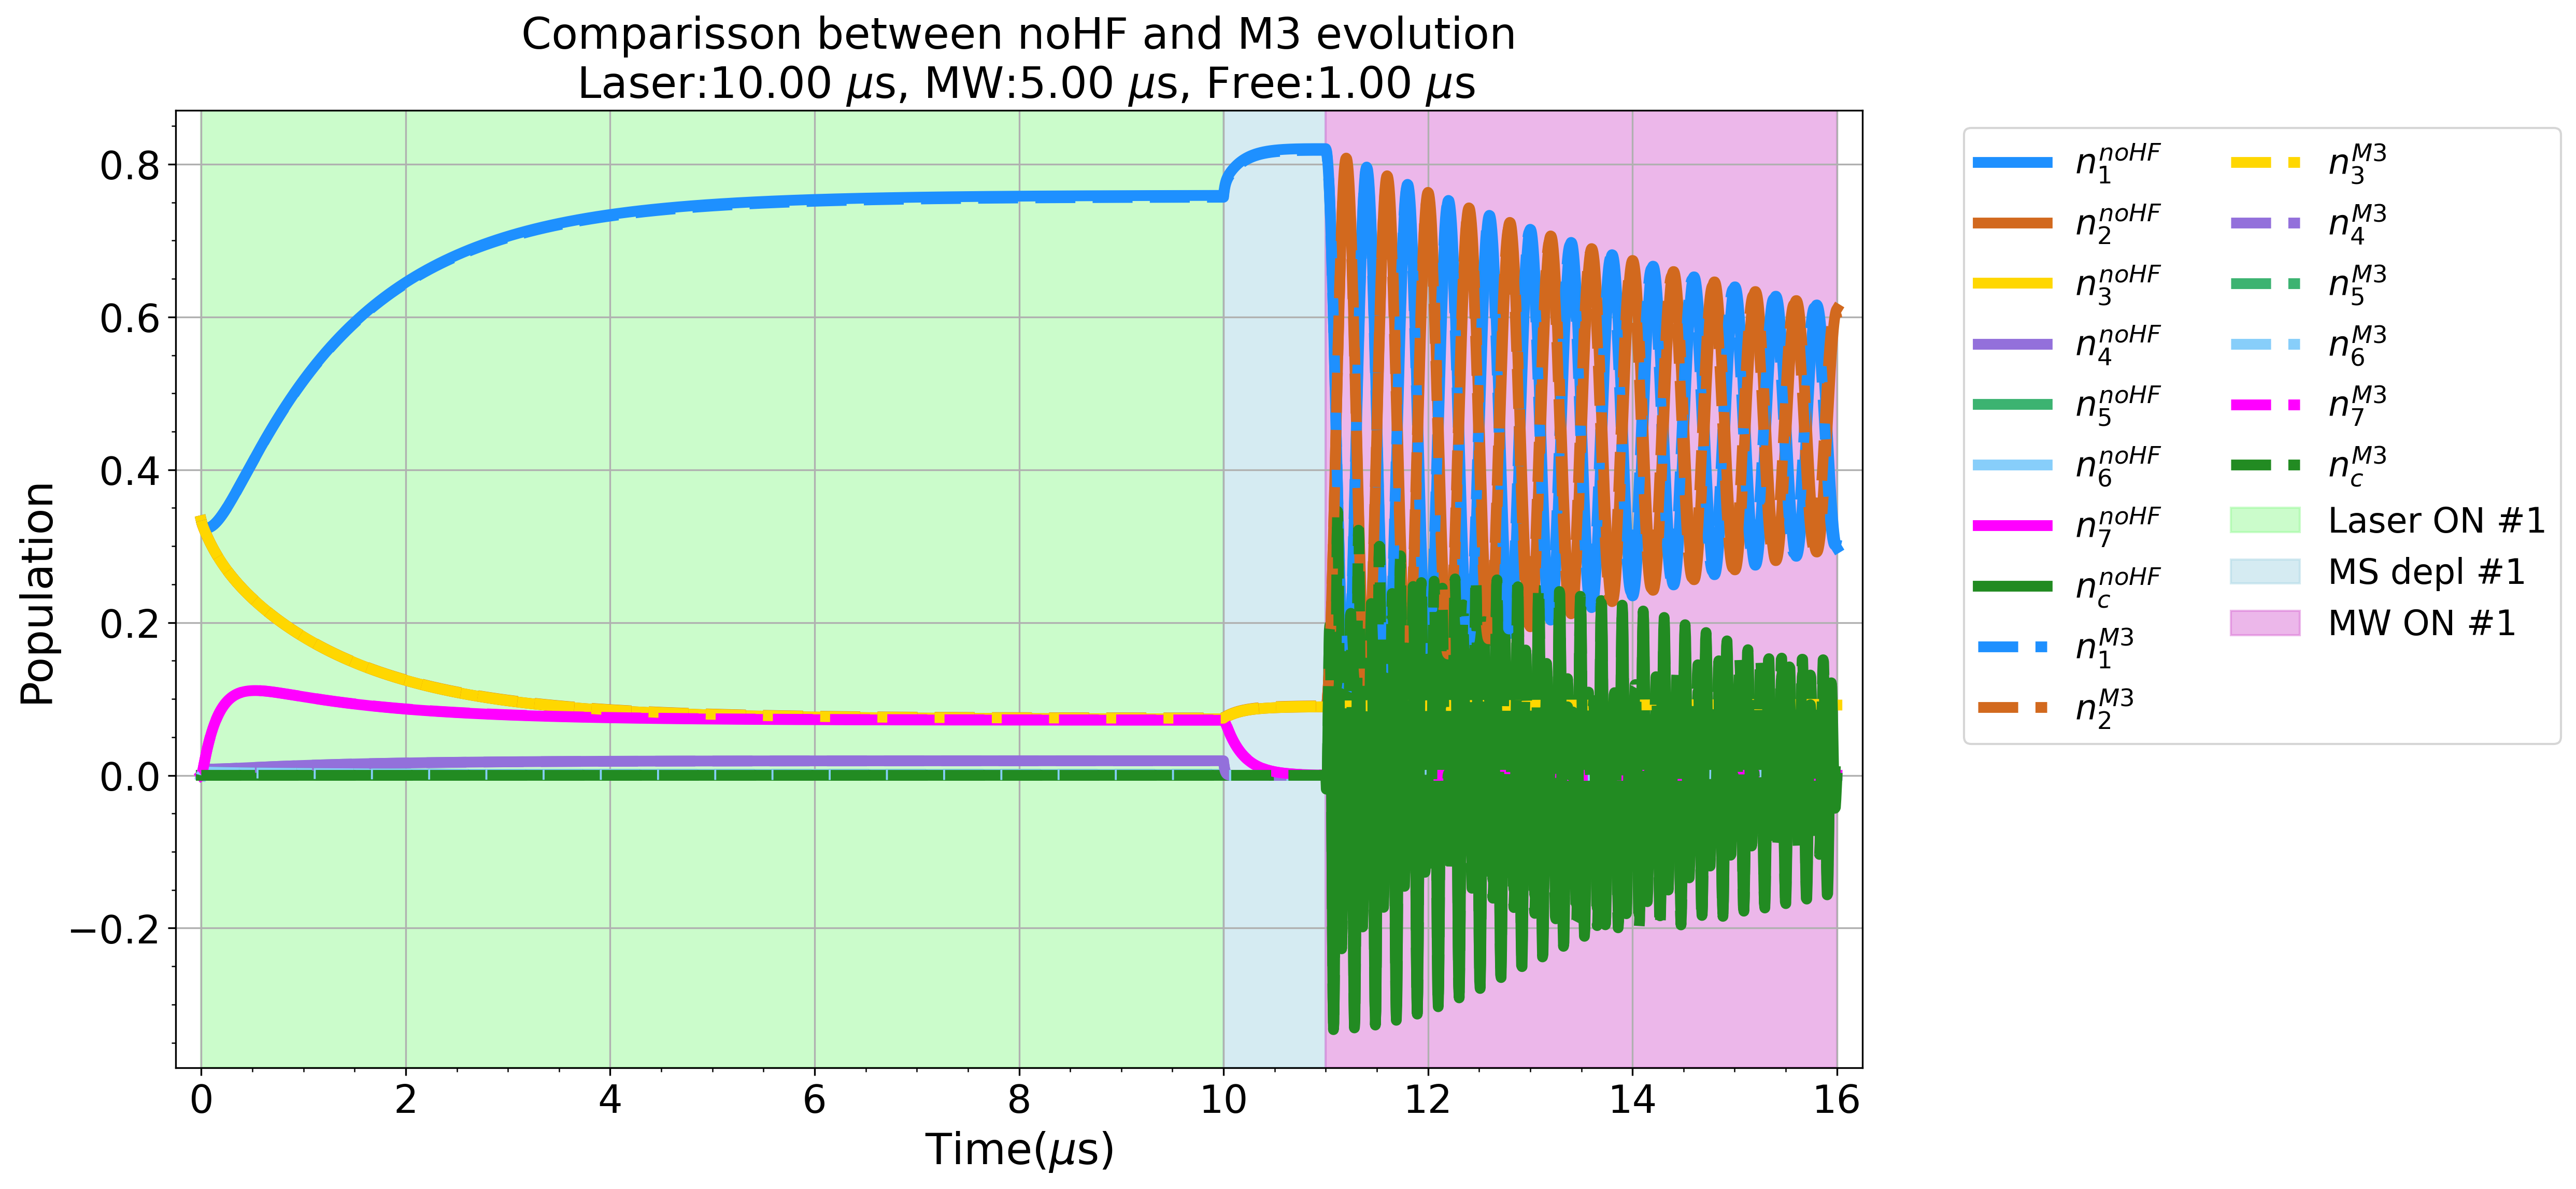

In [12]:
plot_popul_comp(n_exp_m3_no_hf,times_m3_no_hf,tis_m3_no_hf,tfs_m3_no_hf,
                n_exp_m3,times_m3,tis_m3,tfs_m3,
                name_1="{noHF}",name_2="{M3}")

### Comparing with Model 2

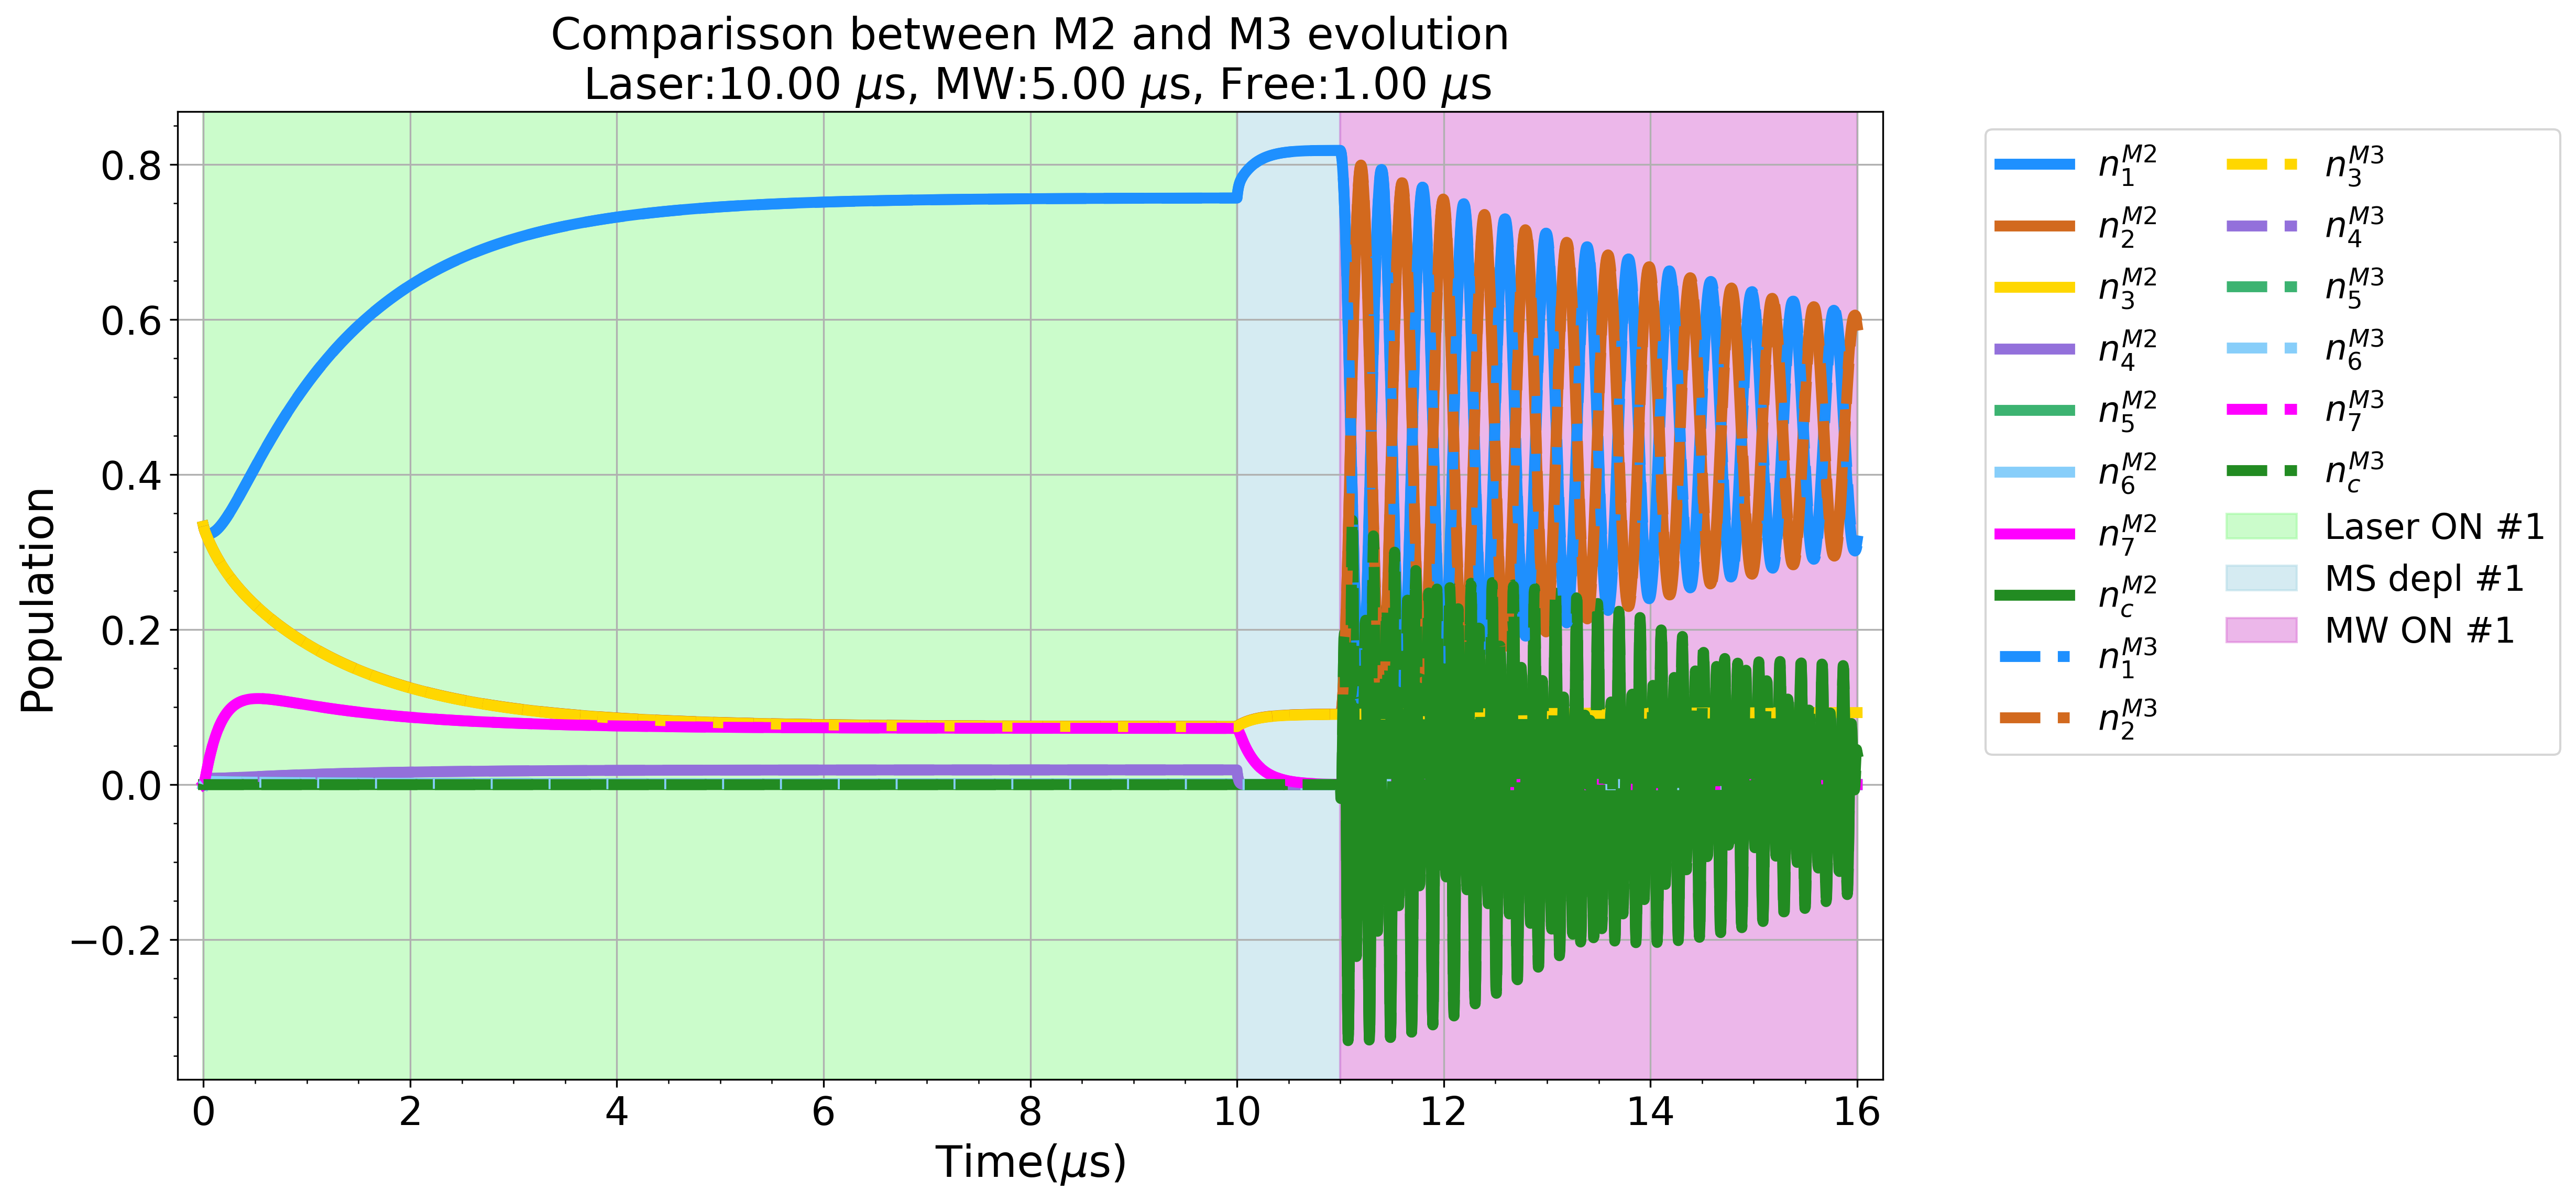

In [13]:
plot_popul_comp(n_exp_m2_hf,times_m2_hf,tis_m2_hf,tfs_m2_hf,
                n_exp_m3,times_m3,tis_m3,tfs_m3,
                name_1="{M2}",name_2="{M3}")

In [14]:
assert(1==2)

AssertionError: 

### Plots

#### Rabi frequencies

In [ ]:
results=np.load("NumpyArrays\\results_bomr.npy",allow_pickle=True)

# Example usage:
# Suppose you have data1 and data2, each with length 300
# And you define three regions:
regions = [(0, 5000), (5000, 6000), (6000, 7000)]
labels  = ["Laser", "Free", "MW"]

# Then call with your actual data:
# summary = compare_regions(data1, data2, regions, labels)


# Example:
# print_summary_table(summary)
# Now plot the results:
for b, omr, Model_3, Model_2, norm in results:
    plot_bomr_doh_vs_dua(Model_3[0], Model_3[1], Model_3[2], Model_3[3],Model_2[0], Model_2[1], Model_2[2], Model_2[3],b, omr)
    # compare deviations nexps of model 3 vs model 2
    colors = [
        "dodgerblue",
        "chocolate",
        "darkgoldenrod",
        "mediumpurple",
        "mediumseagreen",
        "lightskyblue",
        "magenta",
        "forestgreen",
    ]
    print("M3-M2 $Delta n_i")
    plt.figure(figsize=(14, 8))
    for i in range(len(Model_3[0])-1):
        labels  = [f"Laser(n_{i+1})", f"Free(n_{i+1})", f"MW(n_{i+1})"]
        summary = compare_regions(Model_3[0][i], Model_2[0][i], regions, labels)
        print_summary_table(summary)
        plt.plot(Model_3[1], Model_3[0][i]-Model_2[0][i], label=rf"$\Delta n_{i}$", color=colors[i], lw=5)
    labels  = ["Laser(n_c)", "Free(n_c)", "MW(n_c)"]
    summary = compare_regions(Model_3[0][-1], Model_2[0][-1], regions, labels)
    print_summary_table(summary)
    plt.plot(Model_3[1], Model_3[0][-1]-Model_2[0][-1], label=r"$\Delta n_c$", color=colors[-1], lw=5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left",fontsize=20)
    plt.show()
    plot_hf_vs_no_bomrs(Model_3[0], Model_3[1], Model_3[2], Model_3[3],norm[0], norm[1], norm[2], norm[3],b, omr)
    print("M3-N $Delta n_i")
    plt.figure(figsize=(14, 8))
    for i in range(len(norm[0])-1):
        labels  = [f"Laser(n_{i+1})", f"Free(n_{i+1})", f"MW(n_{i+1})"]
        summary = compare_regions(Model_3[0][i], norm[0][i], regions, labels)
        print_summary_table(summary)
        plt.plot(Model_3[1], Model_3[0][i]-norm[0][i], label=rf"$\Delta n_{i}$", color=colors[i], lw=5)
    labels  = ["Laser(n_c)", "Free(n_c)", "MW(n_c)"]
    summary = compare_regions(Model_3[0][-1], norm[0][-1], regions, labels)
    print_summary_table(summary)
    plt.plot(Model_3[1], Model_3[0][-1]-norm[0][-1], label=r"$\Delta n_c$", color=colors[-1], lw=5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left",fontsize=20)
    plt.show()

#### Angles

In [ ]:
results_bang=np.load("NumpyArrays\\results_bang.npy",allow_pickle=True)

# Now plot the results:
for b, p, t, om, Model_3, Model_2, norm in results_bang:
    plot_bang_doh_vs_dua(Model_3[0], Model_3[1], Model_3[2], Model_3[3],
                                Model_2[0], Model_2[1], Model_2[2], Model_2[3],
                                b, p, t, om)
    
    print("M3-M2 $Delta n_i")
    plt.figure(figsize=(14, 8))
    for i in range(len(Model_3[0]-1)):
        labels  = [f"Laser(n_{i+1})", f"Free(n_{i+1})", f"MW(n_{i+1})"]
        summary = compare_regions(Model_3[0][i], Model_2[0][i], regions, labels)
        print_summary_table(summary)
        plt.plot(Model_3[1], Model_3[0][i]-Model_2[0][i], label=rf"$\Delta n_{i}$", color=colors[i], lw=5)
    labels  = ["Laser(n_c)", "Free(n_c)", "MW(n_c)"]
    summary = compare_regions(Model_3[0][i], Model_2[0][i], regions, labels)
    print_summary_table(summary)
    plt.plot(Model_3[1], Model_3[0][i]-Model_2[0][i], label=r"$\Delta n_c$", color=colors[-1], lw=5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left",fontsize=20)
    plt.show()
    plot_hf_vs_no_bangs(Model_3[0], Model_3[1], Model_3[2], Model_3[3],
                               norm[0], norm[1], norm[2], norm[3],
                               b, p, t, om)
    print("M3-N $Delta n_i")
    plt.figure(figsize=(14, 8))
    for i in range(len(norm[0]-1)):
        labels  = [f"Laser(n_{i+1})", f"Free(n_{i+1})", f"MW(n_{i+1})"]
        summary = compare_regions(Model_3[0][i], norm[0][i], regions, labels)
        print_summary_table(summary)
        plt.plot(Model_3[1], Model_3[0][i]-norm[0][i], label=rf"$\Delta n_{i}$", color=colors[i], lw=5)
    labels  = ["Laser(n_c)", "Free(n_c)", "MW(n_c)"]
    summary = compare_regions(Model_3[0][i], norm[0][i], regions, labels)
    print_summary_table(summary)
    plt.plot(Model_3[1], Model_3[0][i]-norm[0][i], label=r"$\Delta n_c$", color=colors[-1], lw=5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left",fontsize=20)
    plt.show()
plt.close('all')

## Extra: 14 Levels

### Rabi Frenquency

In [ ]:
results_bomr_14=np.load('NumpyArrays\\results_bomr_14.npy',allow_pickle=True)

# Now plot the results:
for b, omr, Model_3_14, Model_2_14 in results_bomr_14:
    plot_bomrs_14_doh_vs_dua(Model_3_14[0], Model_3_14[1], Model_3_14[2], Model_3_14[3],
                                Model_2_14[0], Model_2_14[1], Model_2_14[2], Model_2_14[3],
                                b, omr)
plt.close('all')

### Angles

In [ ]:
results_bang_14=np.load("NumpyArrays\\results_bang_14.npy",allow_pickle=True)
# For loky_pmap, you could do:
# from qutip.parallel import loky_pmap
# results = loky_pmap(run_simulation, params, progress_bar="tqdm", num_cpus=8)

# Now plot the results:
for b, p, t, om, Model_3_14, Model_2_14 in results_bang_14:
    plot_bang_14_doh_vs_dua(Model_3_14[0], Model_3_14[1], Model_3_14[2], Model_3_14[3],
                                Model_2_14[0], Model_2_14[1], Model_2_14[2], Model_2_14[3],
                                b, p, t, om)
plt.close('all')